# import modules

In [1]:
import os
import sys
import re
import pickle
import random
import subprocess
import time
import threading
import shutil
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait, ALL_COMPLETED
from datetime import datetime, timedelta
from multiprocessing import Process, Pool

import numpy as np
import pandas as pd
import anndata as ad
import h5py
# import Bio
# from Bio import motifs
import pysam
import pyranges
import pybedtools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import preprocessing
import scipy as sp
import scanpy as sc
from sklearn.cluster import KMeans
from adjustText import adjust_text
# import episcanpy

import SCRIPT
# from giggle import Giggle

In [3]:
import ruamel.yaml
yaml = ruamel.yaml.YAML(typ="safe")
yaml.default_flow_style = False

In [15]:
a = yaml.load("""a:\n  b: 2\n  c: 3\n""")

In [16]:
with open('./test.yml', 'w+') as f:
    yaml.dump(a,f)

In [ ]:
sc.settings.verbosity = 3
# sc.logging.print_header()
sc.logging.print_versions()

# Config

In [2]:
plt.rcParams.update({
    'font.size' : 15,
    'figure.figsize': [8.0, 8.0],
    'font.style' : 'normal',
    'font.weight':'bold',
    'figure.titleweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(220/256, 34/256, N)
vals[:, 1] = np.linspace(220/256, 7/256, N)
vals[:, 2] = np.linspace(220/256, 141/256, N)
regulation_cmp = mpl.colors.ListedColormap(vals)

In [6]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [4]:
human_chip_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/human_ChIP_index'
human_motif_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/human_motif_index'
mouse_chip_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/mouse_ChIP_index'
mouse_motif_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/mouse_motif_index'

In [3]:
I_tf_list = ['I_TBX21', 'I_IRF8', 'I_CEBPA', 'I_CEBPB', 'I_MYB', 'I_BCL11A', 'I_BCL11B', 'I_STAT1', 'I_SOX10', 'I_EBF1', 'I_BRD4']
C_tf_list = [i.replace('I_', 'C_') for i in I_tf_list]
non_tf_list = [i.replace('I_', '') for i in I_tf_list]

# define functions

In [2]:
def add_time(func):
    def wrapper(*args, **kw):
        sys.stdout.write('INFO {time} '.format(time=time.strftime("%Y-%m-%d %H:%M:%S")))
        return func(*args, **kw)
    return wrapper

@add_time
def print_log(string, end="\n"):
    print(string, end=end)

def excute_info(start_info=None, end_info=None):
    def call(func):
        def wrapper(*args, **kwargs):
            if start_info:
                print_log(start_info)
            ret = func(*args, **kwargs)
            if end_info:
                print_log(end_info)
            return ret
        return wrapper
    return call


## generate bed function

In [428]:
def read_SingleCellExperiment_rds(input_RDS):
    import anndata2ri
    from rpy2.robjects import r
    anndata2ri.activate()
    rscript = 'readRDS("{RDS_file_path}")'.format(RDS_file_path = input_RDS)
    adata = r(rscript)
    adata.var.columns = [str(i) for i in adata.var.columns]
    adata.obs.columns = [str(i) for i in adata.obs.columns]
    return adata

In [4]:
def generate_beds(file_path, cells, input_mat, peak_confidence):
    cell_above_cutoff_index = sc.pp.filter_genes(input_mat[cells,:], min_cells=peak_confidence, inplace=False)[0]
    peaks = input_mat.var_names[cell_above_cutoff_index].to_list()
    peaks = pd.DataFrame([p.split("_") for p in peaks])
    peaks.to_csv(file_path, sep="\t", header= None, index=None)
    cmd = 'sort --buffer-size 2G -k1,1 -k2,2n -k3,3n {bed_path} | bgzip -c > {bed_path}.gz\n'.format(bed_path=file_path)
    cmd += 'rm {bed_path}'.format(bed_path=file_path)
    subprocess.run(cmd, shell=True, check=True)

@excute_info('Start generating background beds ...', 'Finished generating background beds!')
def generate_background_bed(input_mat, bg_bed_path, map_dict_store_path, step=50, iteration=1000, peak_confidence=5, n_cores=8):
    map_dict = {}
    if not os.path.exists(bg_bed_path):
        os.makedirs(bg_bed_path)
    cl_name = input_mat.obs_names.to_list()
    total_cnt = iteration
    executor = ThreadPoolExecutor(max_workers=n_cores)
    all_task = []
    for i in range(0,iteration): 
        random.seed(i)
        map_dict[i] = random.sample(cl_name, step)
        all_task.append(executor.submit(generate_beds, bg_bed_path + "/" + str(i) + ".bed", map_dict[i], input_mat, peak_confidence))
    wait(all_task, return_when=ALL_COMPLETED)
    with open(map_dict_store_path, "wb") as map_dict_file:
        pickle.dump(map_dict, map_dict_file)
    return map_dict

@excute_info('Start generating group beds ...', 'Finished generating group beds!')
def generate_cluster_bed(adata, input_mat, bed_path, map_dict_store_path, step=50, cell_cutoff=20, peak_confidence=5):
    metadata = adata.obs
    map_dict = {}
    if not os.path.exists(bed_path):
        os.makedirs(bed_path)
    cluster_info = metadata["seurat_clusters"].unique().to_list()
    for i in cluster_info:
        cluster_cell_name = metadata[metadata['seurat_clusters'] == i].index.to_list()
        start = range(0, len(cluster_cell_name), step)
        j = 0
        for s in start:
            cl_name = cluster_cell_name[s:(s + step)]
            key = str(i) + "_" + str(j)
            map_dict[key] = cl_name
            if len(cl_name) <= cell_cutoff:
                print_log(key + " only have " + str(len(cl_name)), " cells, skip generate bed file.\n")
                continue
            else:
                generate_beds(bed_path + "/" + str(key) + ".bed", map_dict[key], input_mat, peak_confidence)
                j = j+1
    with open(map_dict_store_path, "wb") as map_dict_file:
        pickle.dump(map_dict, map_dict_file)
    return map_dict

def sub_coor_table_in_small_square(cell, coor_table, step, t):
    tmp = coor_table[(coor_table['X'] < coor_table.loc[cell, 'X'] + step * t) & 
                     (coor_table['X'] > coor_table.loc[cell, 'X'] - step * t) &  
                     (coor_table['Y'] < coor_table.loc[cell, 'Y'] + step * t) & 
                     (coor_table['Y'] > coor_table.loc[cell, 'Y'] - step * t)]
    return tmp.copy()

def find_nearest_cells(cell, coor_table, n_neighbor=20, step=None):
#   coor_table has two columns: X, Y, the index of coortable is cell barcodes
    if step == None:
        up_limit = coor_table.max()
        down_limit = coor_table.min()
        width = up_limit.X - down_limit.X
        height = up_limit.Y - down_limit.Y
        step = min(width, height)/200
    t = 1
    tmp = pd.DataFrame()
    while tmp.shape[0] < n_neighbor:
        tmp = sub_coor_table_in_small_square(cell, coor_table, step, t)
        t += 1
    squ_distance = [(tmp.loc[i,"X"] - tmp.loc[cell,"X"])**2 + (tmp.loc[i,"Y"] - tmp.loc[cell,"Y"])**2 for i in tmp.index]
    tmp['distance'] = squ_distance
    tmp = tmp.sort_values(by='distance', ascending=True)
    # since we use square to check the distance, check whether the point is out the circle
    while tmp.iloc[n_neighbor-1, 2] > ((step*t)**2):
        t += 1
        tmp = sub_coor_table_in_small_square(cell, coor_table, step, t)
        squ_distance = [(tmp.loc[i,"X"] - tmp.loc[cell,"X"])**2 + (tmp.loc[i,"Y"] - tmp.loc[cell,"Y"])**2 for i in tmp.index]
        tmp['distance'] = squ_distance
        tmp = tmp.sort_values(by='distance', ascending=True) 
    neighbor_bcs = tmp.index[0:n_neighbor].tolist()
    return neighbor_bcs

@excute_info('Start generating nearest neighbor cells beds ...', 'Finished generating nearest neighbor cells beds!')
def generate_neighbor_bed(adata, input_mat, bed_path, map_dict_store_path, n_neighbor=10, peak_confidence=2, n_cores=8):
    coor_table = pd.DataFrame(adata.obsm['X_umap'], index = adata.obs.index, columns=["X","Y"])
    width = coor_table.max().X - coor_table.min().X
    height = coor_table.max().Y - coor_table.min().Y
    step = min(width, height)/200
    map_dict = {}
    if not os.path.exists(bed_path):
        os.makedirs(bed_path)
    total_cnt = adata.obs.index.__len__()
    executor = ThreadPoolExecutor(max_workers=n_cores)
    all_task = []
#     for clstr in adata.obs['seurat_clusters'].unique().to_list()
#         clstr_cell_list = adata.obs.index[adata.obs['seurat_clusters'] == clstr].to_list()
#         coor_table = coor_table_all.loc[clstr_cell_list,]
    for cell in adata.obs.index:
        neighbor_cells = find_nearest_cells(cell, coor_table, n_neighbor, step)
        map_dict[cell] = neighbor_cells
        all_task.append(executor.submit(generate_beds, bed_path + "/" + str(cell) + ".bed", neighbor_cells, input_mat, peak_confidence))
    wait(all_task, return_when=ALL_COMPLETED)
    with open(map_dict_store_path, "wb") as map_dict_file:
        pickle.dump(map_dict, map_dict_file)
    return map_dict


## search giggle function

In [5]:
def search_giggle(bed_path, result_path, index_path):
#     bed = bed_path.split("/")[-1]
#     if bed_path.endswith('gz'):
    cmd = 'giggle search -i "{index_path}" -s -q "{bed_path}" > "{result_path}"\n'.format(index_path=index_path, result_path=result_path, bed_path=bed_path)
#     print(cmd)
#     else:
#         cmd = 'sort --buffer-size 2G -k1,1 -k2,2n -k3,3n {bed_path} | bgzip -c > {bed_path}.gz\n'.format(bed_path=bed_path)
#         cmd += 'giggle search -i {index_path} -s -q {bed_path}.gz > {result_path}\n'.format(index_path=index_path, result_path=result_path, bed_path=bed_path)
#         cmd += 'rm {bed_path}'.format(bed_path=bed_path)
    subprocess.run(cmd, shell=True, check=True)

def search_giggle_batch(bed_folder, result_folder, index_path, n_cores=8):
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)
    beds = os.listdir(bed_folder)
    args = []
    for bed in beds:
        barcodes = bed[:-7] # remove suffix '.bed.gz'
        args.append((bed_folder + '/' + bed, result_folder + '/' + barcodes + '.txt', index_path))
    with Pool(n_cores) as p:
        p.starmap(search_giggle, args)

# def read_giggle_result(path):
#     """For giggle stored path, return a table, col is cell cluster / cell and row is factor"""
#     file_list = os.listdir(path)
#     print_log('Reading search result in {path}, in total {number} files.'.format(path=path, number=len(file_list)))
#     for i in range(len(file_list)):
#         if i%50 == 0:
#             print_log("finished {percentage:.2f} %".format(percentage = i*100/file_list.__len__()), end="\r")
#         giggle_result = file_list[i]
#         cell_bc = giggle_result[:-4] # remove suffix '.txt'
#         dtframe = pd.read_csv(os.path.join(path, giggle_result), sep="\t", index_col=False)
#         if i == 0:
#             dtframe = dtframe.loc[:,["#file", "combo_score"]]
#             total = dtframe.rename(columns={'combo_score':cell_bc}).copy()
#         else:
#             newcol = dtframe[["combo_score"]]
#             total[cell_bc] = newcol
#     idList = [i.replace(".bed.gz","") for i in total['#file']]
#     total = total.rename(columns={"#file":"id"})
#     total["id"] = idList
#     total = total.set_index("id")
#     return total

def read_giggle_result(files, i):
#     giggle_result = os.path.basename(files[0])
#     cell_bc = giggle_result[:-4] # remove suffix '.txt'
#     dtframe = pd.read_csv(files[0], sep="\t", index_col=False)
#     dtframe = dtframe.loc[:,["#file", "combo_score"]]
#     total = dtframe.rename(columns={'combo_score':cell_bc}).copy()
    for i in range(len(files)):
        giggle_result = os.path.basename(files[i])
        cell_bc = giggle_result[:-4] # remove suffix '.txt'
        dtframe = pd.read_csv(files[i], sep="\t", index_col=False)
        if i == 0:
            dtframe = dtframe.loc[:,["#file", "combo_score"]]
            total = dtframe.rename(columns={'combo_score':cell_bc}).copy()
        else:
            newcol = dtframe[["combo_score"]]
            total[cell_bc] = newcol
    idList = [i[:-7] for i in total['#file']] # remove suffix '.bed.gz'
    total = total.rename(columns={"#file":"id"})
    total["id"] = idList
    total = total.set_index("id")
    return total

def read_giggle_result_batch(path, n_cores=8):
    print_log("Reading searching results, using {n} cores...".format(n=n_cores))
    file_list = os.listdir(path)
    result_split = np.array_split(file_list, n_cores)
    args = [[[os.path.join(path, j) for j in list_chunk], i] for (i, list_chunk) in enumerate(result_split)]
    with Pool(n_cores) as p:
        result = p.starmap(read_giggle_result, args)
    total = pd.concat([i for i in result], axis=1)
    return total


## pvalue calculation function

In [6]:
def cal_hist_auc(arrays, bins = 500):
    """Calculate the AUC of the arrays distribution
    """
    y_score = np.array(arrays)
    hist = arrays.value_counts(bins=bins)
    hist = hist.sort_index()
    append_right = hist.index[bins-1].right
    hist.index = hist.index.left
    # bins is the regions, like [1100, 1200, 1300 ...]
    bins = np.asarray(hist.index)
    # bins[0] = bins[1] - np.diff(bins)[1]
    bins = np.append(bins, append_right)
    # values is the height of each bins, like [0, 0, 1, 2, 0, 1 ...]
    values = np.asarray(hist.values)
    area = sum(np.diff(bins)*values)
    return area, bins, values

def find_bin_idx_of_value(bins, value):
    """Finds the bin which the value corresponds to."""
    array = np.asarray(value)
    idx = np.digitize(array, bins)
    if idx == 0:
        return 0
    return idx-1

def area_after_val(values, bins, val):
    """Calculates the area of the hist after a certain value"""
    left_bin_edge_index = find_bin_idx_of_value(bins, val)
#     bin_width = np.diff(bins)[1]
#     print(bin_width)
    area = sum(np.diff(bins)[left_bin_edge_index:] * values[left_bin_edge_index:])
    return area

# def cal_p(fg_value, bg_area, bg_bins, bg_values):
#     pvalue = area_after_val(bg_values, bg_bins, fg_value)/bg_area
#     if pvalue > 1:
#         pvalue = 1.0
#     return pvalue

# def cal_fc(fg_value, bg_mean):
#     if bg_mean * fg_value > 0: # if mean and value are opposite
#         fc = fg_value / bg_mean
#     elif bg_mean == 0:
#         fc = fg_value
#     else:
#         fc = bg_mean / (bg_mean - fg_value)
#     return fc

# calculate p value by area at the right of curve
# calculate fc by value / background average

def cal_rank(val, bg):
    rank = [i for i in bg if i >= val].__len__()
    if rank == 0:
        rank = 1
    ret = rank/bg.__len__()
    return ret

def cal_rank_table(fg_table, bg_table, i):
    print_log('chunk {i} calculating ...'.format(i=i))
    result_table_p = fg_table.copy()
#     result_table_fc = fg_table.copy()
    for factor in fg_table.index:
        factor_bg = bg_table.loc[factor,:].tolist()
        bg_mean = np.mean(factor_bg)
        bg_std = np.std(factor_bg)
        if bg_mean != 0 and bg_std != 0:
            result_table_p.loc[factor,:] = fg_table.loc[factor,:].apply(cal_rank, **{'bg':factor_bg})
        else:
            result_table_p.loc[factor,:] = 1
#         result_table_fc.loc[factor,:] = fg_table.loc[factor,:].apply(cal_fc, **{'bg_mean': bg_mean})
    print_log('chunk {i} finished calculation!'.format(i=i))
    return result_table_p

def cal_p_table(fg_table, bg_table, i):
    print_log('chunk {i} calculating ...'.format(i=i))
    result_table_p = fg_table.copy()
#     result_table_fc = fg_table.copy()
    for factor in fg_table.index:
        factor_bg = bg_table.loc[factor,:]
        bg_mean = np.mean(factor_bg)
        bg_std = np.std(factor_bg)
        if bg_mean != 0 and bg_std != 0:
            result_table_p.loc[factor,:] = fg_table.loc[factor,:].apply(sp.stats.norm.cdf, args=(bg_mean, bg_std))
        else:
            result_table_p.loc[factor,:] = 0
#         result_table_fc.loc[factor,:] = fg_table.loc[factor,:].apply(cal_fc, **{'bg_mean': bg_mean})
    print_log('chunk {i} finished calculation!'.format(i=i))
    return 1-result_table_p

# def cal_z(score, mean, std):
#     return (score-mean)/std

# def cal_z_table(fg_table, bg_table, i):
#     print_log('chunk {i} calculating ...'.format(i=i))
#     result_table_z = fg_table.copy()
# #     result_table_fc = fg_table.copy()
#     for factor in fg_table.index:
#         factor_bg = bg_table.loc[factor,:]
#         bg_mean = np.mean(factor_bg)
#         bg_std = np.std(factor_bg)
#         if bg_mean != 0 and bg_std != 0:
#             result_table_z.loc[factor,:] = fg_table.loc[factor,:].apply(cal_z, args=(bg_mean, bg_std))
#         else:
#             result_table_z.loc[factor,:] = 0
# #         result_table_fc.loc[factor,:] = fg_table.loc[factor,:].apply(cal_fc, **{'bg_mean': bg_mean})
#     print_log('chunk {i} finished calculation!'.format(i=i))
#     return result_table_z

def cal_p_table_batch(fg_table, bg_table, n_cores=8):
    print_log("Calculating enrichment, divide into {n} chunks...".format(n=n_cores))
    fg_table_split = np.array_split(fg_table, n_cores)
    args = [[table, bg_table, i] for (i, table) in enumerate(fg_table_split)]
    with Pool(n_cores) as p:
        result = p.starmap(cal_rank_table, args)
    print_log("Generating P value table ...")
    result_table_p = pd.concat([i for i in result])
#     print("INFO {time}, Generating FC value table ...".format(time=datetime.now()))
#     result_table_fc = pd.concat([i[1] for i in result])
    print_log('Finished calculation enrichment!')
    return result_table_p

def correct_pvalues_for_multiple_testing(pvalues, correction_type = "Benjamini-Hochberg"):                
    """                                                                                                   
    consistent with R - print correct_pvalues_for_multiple_testing([0.0, 0.01, 0.029, 0.03, 0.031, 0.05, 0.069, 0.07, 0.071, 0.09, 0.1]) 
    modified from https://stackoverflow.com/questions/7450957/how-to-implement-rs-p-adjust-in-python/7453313
    """
    pvalues = np.array(pvalues) 
    n = pvalues.shape[0]     
    new_pvalues = np.empty(n)
    if correction_type == "Bonferroni":   
        new_pvalues = n * pvalues
    elif correction_type == "Bonferroni-Holm": 
        values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]                                      
        values.sort()
        for rank, vals in enumerate(values):                                                              
            pvalue, i = vals
            new_pvalues[i] = (n-rank) * pvalue                                                            
    elif correction_type == "Benjamini-Hochberg":                                                         
        values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]                                      
        values.sort()
        values.reverse()
        new_values = []
        for i, vals in enumerate(values): 
            rank = n - i
            pvalue, index = vals 
            new_values.append((n/rank) * pvalue) 
        for i in range(0, int(n)-1): 
            if new_values[i] < new_values[i+1]:                                                           
                new_values[i+1] = new_values[i]                                                           
        for i, vals in enumerate(values):
            pvalue, index = vals
            new_pvalues[index] = new_values[i]                                                                                                                  
    return new_pvalues

## post processing

In [7]:
@excute_info('Summary result from dataset level to factor level.') 
def map_factor_on_ChIP(table):
    # map factor by id "_"
    factor_index_list = []
    for i in table.index:
        factor_name = i.split("_")
        if len(factor_name) != 2:
            try:
                factor_index_list.append(factor_dict[int(factor_name[0])])
            except:
                print(factor_name)
                factor_index_list.append("None")
        else:
            factor_index_list.append(factor_name[1])
    table["Factor"] = factor_index_list
    return table.groupby("Factor").min()

@excute_info('Extract cell by map dictionary ...', 'Finished all clusters!')
def extract_by_cell_cluster(result_table, map_dict):
    r_table = pd.DataFrame()
    for key in result_table.columns:
        key_cell_number = len(map_dict[key])
        table_index = result_table.index
        cell_bc = map_dict[key]
        new_table_np = np.tile(result_table[key].to_numpy(),[key_cell_number,1]).T
        tmp_table = pd.DataFrame(new_table_np, index = table_index, columns=cell_bc)
        r_table = pd.concat([r_table, tmp_table], axis=1)
    return r_table

def p_to_z_transform(p_table):
    z_table = -np.log10(p_table).T.apply(sp.stats.zscore, axis=0).T.copy()
    return z_table

@excute_info('Generating merged anndata ... ', 'Finished Generating merged anndata!')
def merge_giggle_singlecell_experiment(adata, table, data_type, table2=''):
    # table : each row is a cell, each column is a TF/Gene
    new_adata = adata.copy()
    if data_type == 'integration':
        p_table = table.copy()
        p_table2 = table2.copy()
        new_adata.uns['ChIP_p'] = p_table
        new_adata.uns['motif_p'] = p_table2
        # table1, usually chip_table
        z_table = p_to_z_transform(p_table)
        new_adata.uns['ChIP_z'] = z_table
        # table2, usually motif table
        p_table2 = p_table2.reindex(index = p_table.index)
        z_table2 = p_to_z_transform(p_table2)
        new_adata.uns['motif_z'] = z_table2
        # extract factor
        chip_tfs = z_table.columns.tolist()
        motif_tfs = z_table2.columns.tolist()
        overlap_tf_list = list(set(chip_tfs).intersection(set(motif_tfs)))
        chip_other_tf_list = list(set(chip_tfs) - set(overlap_tf_list))
        motif_other_tf_list = list(set(motif_tfs) - set(overlap_tf_list))
        ovlp_chip_table = z_table[overlap_tf_list]
        ovlp_motif_table = z_table2[overlap_tf_list]
        unique_chip_table = z_table[chip_other_tf_list]
        unique_motif_table = z_table2[motif_other_tf_list]
        ovlp_final_table = pd.DataFrame()
        for ovlp_factor in overlap_tf_list:
            if np.std(ovlp_chip_table[ovlp_factor]) >= np.std(ovlp_motif_table[ovlp_factor]):
                ovlp_final_table[ovlp_factor] = ovlp_chip_table[ovlp_factor]
            else:
                ovlp_final_table[ovlp_factor] = ovlp_motif_table[ovlp_factor]
        final_table = pd.concat([ovlp_final_table,unique_chip_table,unique_motif_table], axis=1)
        final_table.columns = ['I_' + tf for tf in final_table.columns.tolist()]
        new_adata.uns['integrated_z'] = final_table
        new_adata.obs = pd.concat([new_adata.obs, final_table.reindex(new_adata.obs.index.tolist())], axis=1)
#         new_adata.uns['integrated_quantile'] = pd.DataFrame(quantile_transform(final_table.T, axis=0, output_distribution='uniform'), 
#                                                             index=final_table.index, columns=final_table.columns).T
    else:
        p_table = table.copy()
        if data_type == 'ChIP-seq':
            new_adata.uns['ChIP_p'] = p_table
            p_table.columns = ['C_' + tf for tf in p_table.columns.tolist()]
            z_table = p_to_z_transform(p_table)
            new_adata.uns['ChIP_z'] = z_table
        elif data_type == 'motif':
            new_adata.uns['motif_p'] = p_table
            p_table.columns = ['M_' + tf for tf in p_table.columns.tolist()]
            z_table = p_to_z_transform(p_table)
            new_adata.uns['ChIP_z'] = z_table

        new_adata.obs = pd.concat([new_adata.obs, z_table.reindex(new_adata.obs.index.tolist())], axis=1)
#         new_adata.uns['TF_quantile'] = pd.DataFrame(quantile_transform(z_table, axis=0, output_distribution='normal'), 
#                                                                index=z_table.index, columns=z_table.columns)
    return new_adata


## main function

In [8]:
def time_estimate(cell_number, bg_iteration_number, peak_methods, cell_number_per_group, chip_process, motif_process, core):
#   generate bed: 0.5 second per cell,  search index: 10 seconds per cell, cal p: 2 seconds per factor
    if peak_methods == "group":
        bed_number = int(cell_number/cell_number_per_group) + bg_iteration_number
        seconds = 3 * bed_number
        if chip_process == True:
            seconds += 10 * bed_number
        if motif_process == True:
            seconds += 10 * bed_number
    elif peak_methods == "nearest":
        seconds = int(cell_number * core / 50) # single core process, find nearest cells function
        bed_number = cell_number + bg_iteration_number
        seconds += 3 * bed_number
        if chip_process == True:
            seconds += 10 * bed_number
        if motif_process == True:
            seconds += 10 * bed_number
    chip_factor_number = 5069
    motif_factor_number = 1143
    if chip_process == True:
        seconds += 2 * chip_factor_number
    if motif_process == True:
        seconds += 2 * motif_factor_number
    seconds = seconds / core
    now_time = datetime.now()
    future_time = (datetime.now() + timedelta(seconds=seconds)).strftime("%Y-%m-%d %H:%M:%S")
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    elapse = "{hour:0>2d}:{minute:0>2d}:{second:0>2d}".format(hour=int(h), minute=int(m), second=int(s))
    return elapse, future_time    

def check_para(processed_adata, feature_matrix, 
               aggregate_peak_method, cell_number_per_group, cell_cutoff, peak_confidence, 
               fg_bed_path, fg_map_dict_path, 
               bg_bed_path, bg_map_dict_path, bg_iteration, 
               search_chip, chip_index, fg_chip_result_path, bg_chip_result_path,
               search_motif, motif_index, fg_motif_result_path, bg_motif_result_path, 
               integration, store, result_store_path, confirm, clean, n_cores):
    if processed_adata.shape[0] > feature_matrix.shape[0]:
        print_log('WARNING: There are more cells in anndata than input feature matrix.')
    if aggregate_peak_method == 'group':
        if 'seurat_clusters' not in processed_adata.obs:
            print_log('There is no cluster infomation in anndata. "seurat_clusters in .obs is necessary."')
            sys.exit()
    if bg_iteration * cell_number_per_group < feature_matrix.shape[0] * 5:
        print_log('WARNING: Background iteration number less than 5 times number of cell. May be not enough to estimate background.')
    if re.match(r'chr.*_\d*_\d*', feature_matrix.var_names[0]) == None:
        print_log("feature_matrix's index should be like this: chr1_222222_333333. Each row is a feature and each column is a cell.")
        sys.exit()
    if cell_cutoff >= cell_number_per_group or peak_confidence >= cell_number_per_group:
        print_log("cell_cutoff or peak_confidence can not greater than cell_number_per_group.")
        sys.exit()
    if search_chip == True:
        if not os.path.exists(chip_index):
            print_log("chip_index do not exist!")
            sys.exit()
    if search_motif == True:
        if not os.path.exists(motif_index):
            print_log("motif_index do not exist!")
            sys.exit()
    if search_chip != True and search_motif != True:
        print_log("One of search_chip or search_motif must be chosen!")
        sys.exit()
    if store == True and (type(result_store_path) != str or not result_store_path.endswith('.h5ad')):
        print_log("The result_store_path must be set as .h5ad file when store is True!")
        sys.exit()
    # prepare information
    information = '\n~~~~~\nWelcome to use SCRIPT. Here are your settings:\n\n'
    information += 'There are UMAP information and cluster information in your processed_adata. '
    information += 'The aggregate peaks method is {aggregate_peak_method}.\n'.format(aggregate_peak_method=aggregate_peak_method)
    if aggregate_peak_method == 'group':
        information += 'This will aggregate {cell_number_per_group} cells from the same cluster, '.format(cell_number_per_group=cell_number_per_group) 
        information += 'the group that cell number is less than {cell_cutoff} will not generate.\n'.format(cell_cutoff=cell_cutoff)
        information += 'For each group, peaks that confidence is less than {peak_confidence} will be deleted.\n'.format(peak_confidence=peak_confidence)
        information += 'This setting is suitable for the background as well. '
    else:
        information += 'This will borrow peaks from {cell_number_per_group} nearest cells for every cell. '.format(cell_number_per_group=cell_number_per_group)
        information += 'For each cell, peaks that confidence is less than {peak_confidence} will be deleted.\n'.format(peak_confidence=peak_confidence)
    information += 'SCRIPT randomly aggregates {cell_number_per_group} cells peaks '.format(cell_number_per_group=cell_number_per_group)
    information += 'and deletes the peaks that confidence less than {peak_confidence}. '.format(peak_confidence=peak_confidence)
    information += 'This will iterate {bg_iteration} times.\n'.format(bg_iteration=bg_iteration)
    information += 'The background peaks will be stored in {bg_bed_path}, '.format(bg_bed_path=bg_bed_path)
    information += 'foreground peaks will be stored in {fg_bed_path}.\n'.format(fg_bed_path=fg_bed_path)
    if search_chip == True and search_motif == True:
        information += 'SCRIPT will search ChIP-seq and motif index both.\n'
        if integration == True:
            information += 'After that, SCRIPT will integrate into one result based on variability from each result.\n'
    elif search_chip == True:
        information += 'SCRIPT will search ChIP-seq index.\n'
    elif search_motif == True:
        information += 'SCRIPT will search motif index.\n'
    if search_chip == True:
        information += 'ChIP-seq index locates at {chip_index}.\n'.format(chip_index=chip_index)
        information += 'ChIP-seq background result will be stored in {bg_chip_result_path}, '.format(bg_chip_result_path=bg_chip_result_path)
        information += 'foreground result will be stored in {fg_chip_result_path}.\n'.format(fg_chip_result_path=fg_chip_result_path)
    if search_motif == True:
        information += 'Motif index locates at {motif_index}.\n'.format(motif_index=motif_index)
        information += 'Motif background result will be stored in {bg_motif_result_path}, '.format(bg_motif_result_path=bg_motif_result_path)
        information += 'foreground result will be stored in {fg_motif_result_path}.\n'.format(fg_motif_result_path=fg_motif_result_path)
    if store == True:
        information += 'Computed result will be stored in {result_store_path}.\n'.format(result_store_path=result_store_path)
    else:
        information += 'Computed result will not be stored.\n'.format(result_store_path=result_store_path)
    information += 'All folders will{not_string} be removed after processing. '.format(not_string='' if clean == True else ' not')
    information += 'All processes will use {n_cores} cores.\n~~~~~\n'.format(n_cores=n_cores)
    print(information)
        
def process(tp, bg_bed_path, bg_result_path, fg_bed_path, fg_result_path, index, n_cores, fg_map_dict, aggregate_peak_method):
    if tp == 'chip':
        log_list = [
            'Start searching background beds from ChIP-seq index ...',
            'Finished searching background beds from ChIP-seq index!',
            'Start searching foreground beds from ChIP-seq index ...',
            'Finished searching factors from ChIP-seq index!',
            'Finished reading background ChIP-seq index search result!',
            'Finished reading foreground ChIP-seq index search result!'
        ]
    else:
        log_list = [
            'Start searching background beds from motif index ...',
            'Finished searching background beds from motif index!',
            'Start searching foreground beds from motif index ...',
            'Finished searching factors from motif index!',
            'Finished reading background motif index search result!',
            'Finished reading foreground motif index search result!'
        ]
    try:
        if os.listdir(bg_bed_path).__len__() != os.listdir(bg_result_path).__len__():
            shutil.rmtree(bg_result_path)
            print_log(log_list[0])
            search_giggle_batch(bg_bed_path, bg_result_path, index, n_cores)
            print_log(log_list[1])
        else:
            print_log('WARNING: Using existing results, might wrong. If you want to rerun all results, press Ctrl-C to abort and delete {bg_result_path}'.format(bg_result_path=bg_result_path))
    except FileNotFoundError:
        print_log(log_list[0])
        search_giggle_batch(bg_bed_path, bg_result_path, index, n_cores)
        print_log(log_list[1])
    try:
        if os.listdir(fg_bed_path).__len__() != os.listdir(fg_result_path).__len__():
            shutil.rmtree(fg_result_path)
            print_log(log_list[2])
            search_giggle_batch(fg_bed_path, fg_result_path, index, n_cores)
            print_log(log_list[3])
        else:
            print_log('WARNING: Using existing results, might wrong. If you want to rerun all results, press Ctrl-C to abort and delete {fg_result_path}'.format(fg_result_path=fg_result_path))
    except FileNotFoundError:
        print_log(log_list[2])
        search_giggle_batch(fg_bed_path, fg_result_path, index, n_cores)
        print_log(log_list[3])
    bg_result = read_giggle_result_batch(bg_result_path, n_cores)
    print_log(log_list[4])
    result = read_giggle_result_batch(fg_result_path, n_cores)
    print_log(log_list[5])
    result_p = cal_p_table_batch(result, bg_result, n_cores)
    if aggregate_peak_method == "group":
        result_p = extract_by_cell_cluster(result_p.copy(), fg_map_dict)
    if tp == 'chip':
        result_p = map_factor_on_ChIP(result_p).T
    else:
        result_p = result_p.T
    return result_p


def enrich(processed_adata, cell_feature_adata, project='',
           aggregate_peak_method='group', cell_number_per_group=50, cell_cutoff=20, peak_confidence=5, bg_iteration='auto', 
           search_chip=True, chip_index='', search_motif=True, motif_index='',            
           integration=True, store=False, result_store_path='SCRIPT_computed.h5ad',
           confirm=True, clean=True, n_cores=8):
    if project == '':
        tmp_chr_list = [chr(i) for i in range(ord("A"), ord("Z") + 1)] + [chr(i) for i in range(ord("a"), ord("z") + 1)] + [chr(i) for i in range(ord("0"), ord("9") + 1)]
        random.seed(time.time())
        tmp_prefix = str(time.time())[6:13].replace('.','') + '_' + ''.join(random.sample(tmp_chr_list, 4))
        fg_bed_path='.SCRIPT_temp/{tmp_prefix}/fg_bed'.format(tmp_prefix = tmp_prefix)
        fg_map_dict_path='.SCRIPT_temp/{tmp_prefix}/fg_bed.pk'.format(tmp_prefix = tmp_prefix)
        bg_bed_path='.SCRIPT_temp/{tmp_prefix}/bg_bed'.format(tmp_prefix = tmp_prefix)
        bg_map_dict_path='.SCRIPT_temp/{tmp_prefix}/bg_bed.pk'.format(tmp_prefix = tmp_prefix)
        fg_chip_result_path='.SCRIPT_temp/{tmp_prefix}/fg_chip_result'.format(tmp_prefix = tmp_prefix)
        bg_chip_result_path='.SCRIPT_temp/{tmp_prefix}/bg_chip_result'.format(tmp_prefix = tmp_prefix)
        fg_motif_result_path='.SCRIPT_temp/{tmp_prefix}/fg_motif_result'.format(tmp_prefix = tmp_prefix)
        bg_motif_result_path='.SCRIPT_temp/{tmp_prefix}/bg_motif_result'.format(tmp_prefix = tmp_prefix)
    else:
        fg_bed_path='{project}/fg_bed'.format(project = project)
        fg_map_dict_path='{project}/fg_bed.pk'.format(project = project)
        bg_bed_path='{project}/bg_bed'.format(project = project)
        bg_map_dict_path='{project}/bg_bed.pk'.format(project = project)
        fg_chip_result_path='{project}/fg_chip_result'.format(project = project)
        bg_chip_result_path='{project}/bg_chip_result'.format(project = project)
        fg_motif_result_path='{project}/fg_motif_result'.format(project = project)
        bg_motif_result_path='{project}/bg_motif_result'.format(project = project)
    ##################################
    ### pre-check
    ##################################
    print_log('Checking paramaters ...')
    if bg_iteration == "auto":
        bg_iteration = int(processed_adata.shape[0] * 5 / cell_number_per_group) + 1
    check_para(processed_adata, cell_feature_adata, 
               aggregate_peak_method, cell_number_per_group, cell_cutoff, peak_confidence, 
               fg_bed_path, fg_map_dict_path, 
               bg_bed_path, bg_map_dict_path, bg_iteration, 
               search_chip, chip_index, fg_chip_result_path, bg_chip_result_path,
               search_motif, motif_index, fg_motif_result_path, bg_motif_result_path, 
               integration, store, result_store_path, confirm, clean, n_cores)
    print_log('Estimating running time ...')
    elapse, future_time = time_estimate(cell_number = cell_feature_adata.shape[0], bg_iteration_number=bg_iteration, 
                                        peak_methods=aggregate_peak_method, cell_number_per_group=cell_number_per_group, 
                                        chip_process=search_chip, motif_process=search_motif, core=n_cores)
    print_log("It will take about {elapse} to process and finish at {future_time}.\n".format(elapse = elapse, future_time = future_time))
    if confirm == True:
        print('Type "Y" to continue processing, "N" to abort.')
        while True:
            confirm_info = input()
            if confirm_info == 'y' or confirm_info == 'Y':
                break
            elif confirm_info == 'N' or confirm_info == 'n':
                print_log('Good Bye!')
                sys.exit(0)
            else:
                print('Please type Y / N.')
    ##################################
    ### bed generation
    ##################################
    # generate background peak, if length same as iteration, we consider it has estimated, skip generation.
    # if user generate same length background, but diff depth, may report unaccurate result.
    if os.path.exists(bg_bed_path):
        if os.listdir(bg_bed_path).__len__() != bg_iteration:
            shutil.rmtree(bg_bed_path)
            print_log('Not empty folder, removed existing files!')
            bg_map_dict = generate_background_bed(cell_feature_adata, bg_bed_path, bg_map_dict_path, cell_number_per_group, bg_iteration, peak_confidence, n_cores)
        else:
            print_log('WARNING: Using existing results, might wrong. If you want to rerun all results, press Ctrl-C to abort and delete {bg_bed_path}'.format(bg_bed_path=bg_bed_path))
            with open(bg_map_dict_path, "rb") as map_dict_file:
                bg_map_dict = pickle.load(map_dict_file)
    else:
        bg_map_dict = generate_background_bed(cell_feature_adata, bg_bed_path, bg_map_dict_path, cell_number_per_group, bg_iteration, peak_confidence, n_cores)
    # if user generated foregroud, but diff depth in same folder, may report unaccurate result.
    # this is fast, we just remove it.
    if aggregate_peak_method == "group":
        if os.path.exists(fg_bed_path):
            shutil.rmtree(fg_bed_path)
        fg_map_dict = generate_cluster_bed(processed_adata, cell_feature_adata, fg_bed_path, fg_map_dict_path, cell_number_per_group, cell_cutoff, peak_confidence)
    # generate foreground peaks, if length same as cell number, we consider it has estimated, skip generation.
    # if user generate same length background, but diff depth in same folder, may report unaccurate result.
    if aggregate_peak_method == "nearest":
        if os.path.exists(fg_bed_path):
            if os.listdir(fg_bed_path).__len__() != processed_adata.shape[0]:
                shutil.rmtree(fg_bed_path)
                print_log('Not empty folder, removed existing files!')
                fg_map_dict = generate_neighbor_bed(processed_adata, cell_feature_adata, fg_bed_path, fg_map_dict_path, 
                                                    cell_number_per_group, peak_confidence, n_cores)
            else:
                print_log('WARNING: Using existing results, might wrong. If you want to rerun all results, press Ctrl-C to abort and delete {fg_bed_path}'.format(fg_bed_path=fg_bed_path))
                with open(fg_map_dict_path, "rb") as map_dict_file:
                    fg_map_dict = pickle.load(map_dict_file)
        else:
            fg_map_dict = generate_neighbor_bed(processed_adata, cell_feature_adata, fg_bed_path, fg_map_dict_path, 
                                                cell_number_per_group, peak_confidence, n_cores)
    ##################################
    ### Search giggle and compute enrich score
    ##################################
    if search_chip == True:
        chip_result_p = process('chip', bg_bed_path, bg_chip_result_path, fg_bed_path, fg_chip_result_path, 
                                chip_index, n_cores, fg_map_dict, aggregate_peak_method)
    if search_motif == True:
        motif_result_p = process('motif', bg_bed_path, bg_motif_result_path, fg_bed_path, fg_motif_result_path, 
                                motif_index, n_cores, fg_map_dict, aggregate_peak_method)
    ##################################
    ### Summary results
    ##################################
    if search_chip == True and search_motif == True:
        if integration == True:
            regulation_adata = merge_giggle_singlecell_experiment(processed_adata, chip_result_p, 'integration', motif_result_p)
        else:
            regulation_adata = merge_giggle_singlecell_experiment(processed_adata, chip_result_p, 'ChIP-seq')
            regulation_adata = merge_giggle_singlecell_experiment(regulation_adata, motif_result_p, 'motif')
    elif search_chip == True and search_motif != True:
        regulation_adata = merge_giggle_singlecell_experiment(processed_adata, chip_result_p, 'ChIP-seq')
    else:
        regulation_adata = merge_giggle_singlecell_experiment(processed_adata, motif_result_p, 'motif')
    if result_store_path:
        regulation_adata.write(result_store_path)
    ##################################
    ### Clean files
    ##################################
    if clean == True:
        try:
            shutil.rmtree(fg_bed_path)
            shutil.rmtree(bg_bed_path)
            if search_chip == True:
                shutil.rmtree(fg_chip_result_path)
                shutil.rmtree(bg_chip_result_path)
            if search_motif == True:
                shutil.rmtree(fg_motif_result_path)
                shutil.rmtree(bg_motif_result_path)
        except:
            pass
    return regulation_adata


## RP calculation

In [9]:
# def ExtractGeneInfo(gene_bed):
#     """Extract gene information from gene bed file."""

#     bed = pd.read_csv(gene_bed, sep="\t", header=0, index_col=False)
#     bed['transcript'] = [x.strip().split(".")[0] for x in bed['name'].tolist()]
#     bed['tss'] = bed.apply(lambda x: x['txStart'] if x['strand']=='+' else x['txEnd'], axis=1)

#     ### adjacent P+GB
#     bed["start"] = bed.apply(lambda x: x['txStart']-2000 if x['strand']=='+' else x['txStart'], axis=1)
#     bed["end"] = bed.apply(lambda x: x['txEnd']+2000 if x['strand']=='-' else x['txEnd'], axis=1)
    
#     bed['promoter'] = bed.apply(lambda x: tuple([x['tss']-2000, x['tss']+2000]), axis=1)
#     bed['exons'] = bed.apply(lambda x: tuple([(int(i), int(j)) for i, j in zip(x['exonStarts'].strip(',').split(','), x['exonEnds'].strip(',').split(','))]), axis=1)

#     ### exon length
#     bed['length'] = bed.apply(lambda x: sum(list(map(lambda i: (i[1]-i[0])/1000.0, x['exons']))), axis=1)
#     bed['uid'] = bed.apply(lambda x: "%s@%s@%s"%(x['name2'], x['start'], x['end']), axis=1)
#     bed = bed.drop_duplicates(subset='uid', keep="first")
#     gene_info = []
#     for irow, x in bed.iterrows():
#         gene_info.append([x['chrom'], x['start'], x['end'], x['tss'], x['promoter'], x['exons'], x['length'], 1, x['uid']])
#     ### [chrom_0, start_1, end_2, tss_3, promoter_4, exons_5, length_6(kb), 1_7, uid_8(genename@start@end)]
#     return gene_info

In [117]:
def geneInfoSimple(gene_bed):
    genes_info = []
    genes_list = []
    fhd = open(gene_bed, 'rt')
    fhd.readline() # skip the first line. In our current gene txt file, there is no '#' in the first line. We need to, perhaps, use the 'ExtractGeneInfo' function.
    for line in fhd:
        line = line.strip().split('\t')
        if not line[0].startswith('#'):
            if line[3] == "+":
                genes_info.append((line[2], int(line[4]), 1, "%s@%s@%s" % (line[12], line[2], line[4])))
            else:
                genes_info.append((line[2], int(line[5]), 1, "%s@%s@%s" % (line[12], line[2], line[5])))
                # gene_info [chrom, tss, 1, gene_unique]
    fhd.close()
    genes_info = list(set(genes_info))
    for igene in range(len(genes_info)):
        tmp_gene = list(genes_info[igene])
        genes_list.append(tmp_gene[3])
        tmp_gene[3] = igene
        genes_info[igene] = tmp_gene
    return genes_info, genes_list

In [118]:
def RP_Simple(peaks_info, genes_info, decay):
    """Multiple processing function to calculate regulation potential."""

    Sg = lambda x: 2**(-x)
    gene_distance = 15 * decay
    genes_peaks_score_array = sp.sparse.dok_matrix((len(genes_info), len(peaks_info)), dtype=np.float64)

    w = genes_info + peaks_info

    A = {}

    w.sort()
    for elem in w:
        if elem[2] == 1:
            A[elem[-1]] = [elem[0], elem[1]]
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = abs(elem[1] - g[1])
                if (g[0] != elem[0]) or (tmp_distance > gene_distance):
                    dlist.append(gene_name)
                else:
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
            for gene_name in dlist:
                del A[gene_name]

    w.reverse()
    for elem in w:
        if elem[2] == 1:
            A[elem[-1]] = [elem[0], elem[1]]
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = abs(g[1] - elem[1])
                if (g[0] != elem[0]) or (tmp_distance > gene_distance):
                    dlist.append(gene_name)
                else:
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
            for gene_name in dlist:
                del A[gene_name]

    return(genes_peaks_score_array)

In [119]:
def cal_neighbor_cell_peak_mat(table, input_mat, coor_table, impute_n, i):
    print(i)
    for cell_barcode in table.index:
        nearest_bc = find_nearest_cells(cell_barcode, coor_table, n_neighbor=impute_n)
#         table.loc[cell_barcode,:] = [1 if i else 0 for i in input_mat.loc[nearest_bc,:].sum() >= 1]
        table.loc[cell_barcode,:] = input_mat.loc[nearest_bc,:].sum()
    return table

def cal_neighbor_cell_peak_mat_batch(input_mat, coor_table, impute_n, n_cores=8):
    print_log("Calculating enrichment, divide into {n} chunks...".format(n=n_cores))
    input_table_split = np.array_split(input_mat, n_cores)
    args = [[table, input_mat, coor_table, impute_n, i] for (i, table) in enumerate(input_table_split)]
    with Pool(n_cores) as p:
        result = p.starmap(cal_neighbor_cell_peak_mat, args)
    cell_peak = pd.concat([i for i in result])
    print_log('finished!')
#     return sp.sparse.csr_matrix(cell_peak)
    return cell_peak

# Cell Line

## load data

In [3]:
atac_adata = sc.read_h5ad('example/cellline/cellline_script/enrichment/SCRIPT_enrichment.h5ad')

In [26]:
# seurat_adata = ad.read_h5ad('example/10X_ATAC/10X_ATAC_PBMC.h5ad')
# atac_seurat_adata = ad.read_h5ad('example/PBMC/data/PBMC_granulocyte_sorted_10k_scATAC_Object.h5ad')

In [511]:
atac_adata.obs['assign.celltype'] = atac_adata.obs['assign.celltype'].astype('str')
for i in atac_adata.obs.index:
    rna_bc = keys.loc[i,'RNA']
    try:
        atac_adata.obs.loc[i, 'assign.celltype'] = str(rna_adata.obs.loc[rna_bc,'assign.ident'])
    except:
        atac_adata.obs.loc[i, 'assign.celltype'] = 'N'
atac_adata.obs['assign.celltype'] = atac_adata.obs['assign.celltype'].astype("category")

In [52]:
ac_celltype=[]
for i in atac_adata.obs.index:
    if i.split('-')[2] != 'well':
        ac_celltype.append('-'.join(i.split('-')[1:3]))
    else:
        ac_celltype.append(i.split('-')[1])       


In [20]:
celltype=['-'.join(i.split('-')[1:2]) for i in atac_adata.obs.index]

In [24]:
atac_adata.obs

,orig.ident,nCount_ATAC,nFeature_ATAC,ATAC_snn_res.0.6,seurat_clusters,nCount_ACTIVITY,nFeature_ACTIVITY,assign.ident,assign.score,assign.celltype,...,I_CXXC1,I_ISX,I_NFATC2,I_ZNF177,I_ZNF704,I_KDM2A,I_CXXC5,I_UNCX,I_IRX2,I_MEIS2
singles-K562-JNKi-well-1,example/cellline/ATAC,934.0,934,3,3,1006.383867,2314,Neutrophils,0.045595,K562,...,-0.679643,1.680383,1.680383,-0.535085,-0.679643,-0.679643,-0.676555,1.680383,-0.659230,-0.674480
singles-H1ESC-well-79,example/cellline/ATAC,10423.0,10423,6,6,13028.769280,19195,CD4Tconv,0.401454,H1ESC,...,-0.792692,-0.807500,-0.805423,-0.806809,-0.650225,-0.807155,0.781855,-0.807155,1.576533,-0.762203
singles-GM-TNFa6h-well-1,example/cellline/ATAC,4221.0,4221,0,0,4509.403365,10438,B,1.064182,GM,...,-0.735141,-0.684485,-0.582748,0.543405,-0.734578,-0.735704,1.150809,-0.622655,-0.431105,-0.689394
singles-GM-TNFa6h-well-77,example/cellline/ATAC,716.0,716,2,2,779.776330,2374,CD4Tconv,0.091231,GM,...,-0.700003,1.562383,1.562383,1.562383,-0.700003,-0.700003,-0.700003,1.562383,-0.700003,0.281141
singles-GM-rep1-well-77,example/cellline/ATAC,505.0,505,2,2,530.518487,1858,CD4Tconv,0.091231,GM,...,-0.693799,1.568097,1.568097,1.568097,-0.693799,-0.693799,-0.693799,1.568097,-0.693799,-0.554751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
singles-GM-rep4-well-77,example/cellline/ATAC,1193.0,1193,2,2,1307.616767,3461,CD4Tconv,0.091231,GM,...,-0.671648,1.673258,1.673258,-0.528015,-0.671648,-0.671648,-0.671648,1.673258,-0.671648,-0.653878
singles-TF1-well-88,example/cellline/ATAC,4005.0,4005,10,10,4540.531392,10941,Mast,0.357857,TF1,...,-0.733651,-0.521015,-0.006290,-0.600810,-0.733651,-0.733651,-0.203905,-0.595933,-0.317832,0.116443
singles-GM-rep1-well-95,example/cellline/ATAC,860.0,860,2,2,1007.330239,1887,CD4Tconv,0.091231,GM,...,-0.683806,1.572922,1.572922,0.440684,-0.683806,-0.683806,-0.683806,1.572922,-0.683806,-0.683479
singles-K562-rep1-well-125,example/cellline/ATAC,11166.0,11166,5,5,12536.713617,18365,Plasma,0.173415,K562,...,-0.803860,-0.804579,-0.795117,0.680553,-0.745365,-0.804579,1.676319,-0.804219,0.929494,-0.573843


In [53]:
atac_adata.obs['assign.celltype'] = celltype
atac_adata.obs['assign.celltype'] = atac_adata.obs['assign.celltype'].astype("category")
atac_adata.obs['assign.accurate.celltype'] = ac_celltype
atac_adata.obs['assign.accurate.celltype'] = atac_adata.obs['assign.accurate.celltype'].astype("category")

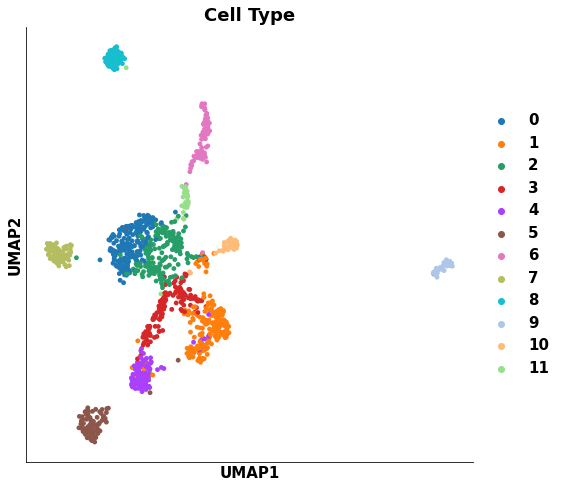

In [25]:
sc.pl.umap(atac_adata, color=['seurat_clusters'], title='Cell Type')

In [121]:
pbmc_10X_inputMat = sc.read_10x_h5('example/PBMC/data/PBMC_granulocyte_sorted_10k_peak_count.h5', gex_only=False)

In [ ]:
# pbmc_script_adata = enrich( processed_adata=seurat_adata, 
#                             cell_feature_adata=pbmc_10X_inputMat, 
#                             project='example/10X_ATAC/SCRIPT_result_20210125_%s/' % i,
#                             aggregate_peak_method="nearest", 
#                             cell_number_per_group=i, 
#                             cell_cutoff=int(i/3), 
#                             peak_confidence=int(i/5), 
#                             bg_iteration=1000,  
#                             search_chip=True, 
#                             chip_index=human_chip_index, 
#                             search_motif=True, 
#                             motif_index=human_motif_index, 
#                             integration=True, 
#                             confirm=False, 
#                             store=True,
#                             result_store_path='example/10X_ATAC/SCRIPT_result_20210125_%s/10X_ATAC_script_computed_20210111.h5ad' % i,
#                             clean=False, 
#                             n_cores=24
#                            )

In [26]:
script_adata = ad.read_h5ad('example/cellline/cellline_script/enrichment/SCRIPT_enrichment.h5ad')

In [ ]:
script_adata.obs = script_adata.obs.drop(script_adata.obs.columns[11:], axis=1)
tmp  =  script_adata.uns['ChIP_p'].copy()
tmp.columns=['C_'+i for i in tmp.columns]
script_adata.obs = pd.concat([script_adata.obs, tmp.reindex(script_adata.obs.index.tolist())], axis=1)

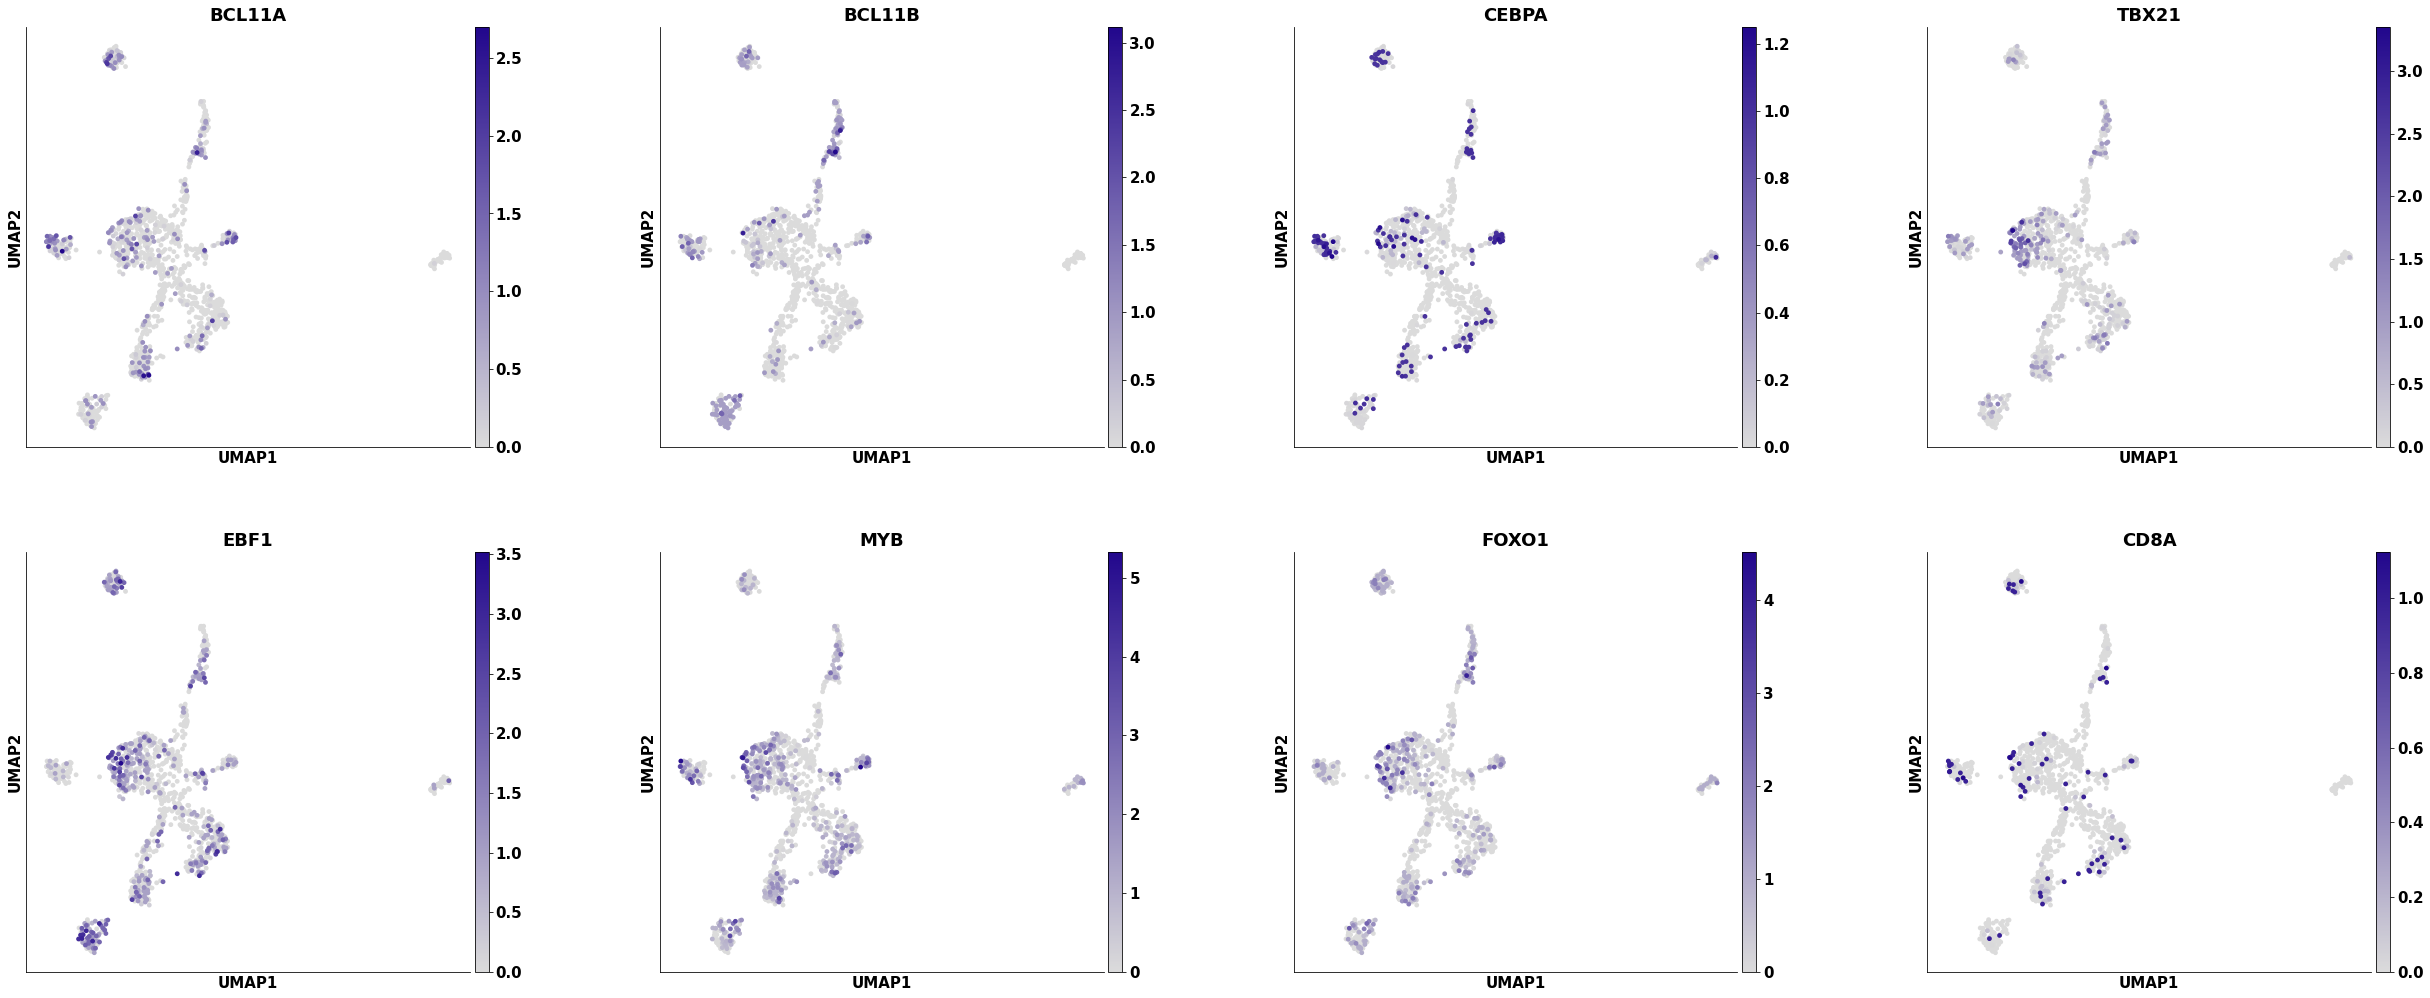

In [27]:
sc.pl.umap(script_adata, color=['BCL11A','BCL11B','CEBPA','TBX21','EBF1', 'MYB', 'FOXO1','CD8A'], wspace=0.3, color_map=regulation_cmp)

C_TBX21","C_IRF8","C_CEBPA","C_CEBPB","C_MYB","C_BCL11A","C_BCL11B","C_STAT1","C_SOX10","C_EBF1","C_BRD4


In [ ]:
sc.pl.umap(pbmc_script_adata, color=I_tf_list, wspace=0.3, color_map=regulation_cmp)

# Plot

In [522]:
chromVAR_table.T

,TFAP2B,TFAP2D,TFAP2C,TFAP2E,TFAP2A,ARID3A,ARID5B,ARID3B,ARID5A,ARID3C,...,PBX4,NKX62,HOXA4,CR8477943,RORB,SMAD5,SMAD9,SOX6,TBX18,TBX22
AAACAAGCACCACAAA,1.303155,-0.434590,-0.457119,0.965786,1.826718,0.222399,0.496754,-0.528345,-1.312826,-0.526592,...,0.842919,-0.305863,0.971412,0.427137,-1.044701,-0.917601,-0.342049,-0.336527,1.151196,1.151196
AAACAAGCAGCCAGTG,-0.976182,-1.168322,-0.749624,0.111072,-1.766978,1.799998,-0.155039,-0.134317,-0.192148,-1.253129,...,-0.720390,-0.669256,0.848806,1.072767,-1.286486,-0.828982,0.438613,-0.563324,-0.276718,-0.276718
AAACAAGCAGGACCTG,-0.306004,0.017620,-2.098204,-0.322960,0.011830,0.517261,1.146561,-0.352097,1.455611,1.236955,...,1.297821,0.715016,-0.548809,-1.734624,0.300097,0.831536,0.480913,0.069200,-0.268239,-0.268239
AAACAAGCATTGACTC,-1.007423,0.323479,-1.280677,-0.166447,0.446602,1.483417,-0.550072,1.051917,-0.922795,1.730456,...,0.060741,1.454022,1.212289,-1.754932,-0.939455,-0.047612,-0.010529,-0.102109,1.562885,1.562885
AAACAAGCATTGTTTG,-0.730665,-2.272845,-1.342869,0.210156,-0.269242,1.594789,2.052390,-0.832631,-0.345750,-0.674169,...,0.286168,-0.039768,-0.742604,1.295154,1.026998,-0.273359,-2.540347,-0.008690,0.580615,0.580615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCGAGGTGGCTA,-0.013423,-0.799812,0.496376,0.917468,0.017925,0.169166,-0.353570,0.610647,1.344225,-1.007314,...,0.536884,0.813049,1.305287,-0.697667,1.368993,-0.547129,-0.603766,0.577488,-1.279311,-1.279311
TTTGTGAGTACCTTGG,1.685638,0.145448,-0.257251,-0.655742,-0.480001,1.011504,2.912024,1.957431,1.021042,0.636026,...,1.403189,2.490445,1.535583,1.330865,2.118625,-0.473756,-0.481643,0.214739,2.689893,2.689893
TTTGTGAGTCATGAAG,0.623155,-0.161078,-0.115077,-1.991842,-2.108227,0.748301,-2.055235,2.969763,-0.743320,1.941854,...,-0.655526,0.041744,-0.956059,-0.746708,-0.027294,1.116511,-0.517152,1.549040,0.364667,0.364667
TTTGTGAGTGCAATAG,-1.938859,-0.064810,-1.381009,-1.163329,0.697171,1.176247,0.303462,-0.235745,0.805261,-1.139156,...,-0.156648,-0.144521,0.325093,0.590291,0.587448,1.176031,0.029297,0.091389,-1.017517,-1.017517


In [611]:
expression = pd.read_csv('example/PBMC/cluster_expr.txt', sep='\t', index_col=0)
# expression = np.log(expression + 0.00001)

chromVAR_table = pd.read_csv('example/PBMC/chromVAR_ztable.txt', sep='\t').T

# pbmc_script_adata = ad.read_h5ad('example/PBMC/multiome_pbmc_SCRIPT/enrichment/SCRIPT_enrichment.h5ad')

script_table = pbmc_script_adata.uns['integrated_z']

metadata = atac_adata.obs

In [ ]:
script_table

In [632]:
atac_adata

AnnData object with n_obs × n_vars = 11863 × 28307
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'ATAC_snn_res.0.6', 'seurat_clusters', 'nCount_ACTIVITY', 'nFeature_ACTIVITY', 'assign.ident', 'assign.score', 'assign.celltype', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'assign.celltype_colors'
    obsm: 'LSI', 'X_umap'
    layers: 'logcounts'

### SCRIPT chromVAR Expression

In [111]:
chromVAR_dict = {}
SCRIPT_dict = {}
for i in expression.columns:
    locals()[i+'_cells'] = metadata[(metadata['assign.celltype'] == i)].index
    locals()[i] = chromVAR_table.loc[locals()[i+'_cells'],].mean()
    chromVAR_dict[i] = locals()[i]
    locals()[i] = script_table.loc[locals()[i+'_cells'],].mean()
    SCRIPT_dict[i] = locals()[i]

In [112]:
SCRIPT_table = pd.DataFrame(SCRIPT_dict)
chromVAR_table = pd.DataFrame(chromVAR_dict)

In [113]:
SCRIPT_table.index = [i[2:] for i in SCRIPT_table.index]

In [ ]:
SCRIPT_table = SCRIPT_table.drop(['CPEB1','ZNF354C'])

In [74]:
sc_ovlp_factor = list(set(SCRIPT_table.index.to_list())  & set(expression.index.to_list()))
ch_ovlp_factor = list(set(chromVAR_table.index.to_list())  & set(expression.index.to_list()))

In [114]:
ovlp_factor = list(set(SCRIPT_table.index.to_list())  & set(expression.index.to_list()) & set(chromVAR_table.index.to_list()))

In [20]:
ovlp_factor

['TBX5',
 'SMARCC1',
 'ERG',
 'CENPB',
 'FOXO3',
 'EGR4',
 'PBX1',
 'MAFK',
 'NR1H3',
 'E2F6',
 'BHLHE40',
 'NFE2L2',
 'KLF12',
 'MAFB',
 'TBP',
 'E2F1',
 'OSR1',
 'IRF3',
 'ETV6',
 'USF2',
 'JUNB',
 'BATF3',
 'RFX1',
 'RUNX3',
 'CREB1',
 'ZHX1',
 'MYB',
 'ID3',
 'FLI1',
 'TBX3',
 'IRF4',
 'PAX9',
 'ATF3',
 'SMARCC2',
 'INSM1',
 'POU2F1',
 'FOXA3',
 'BCL6',
 'KLF5',
 'CRX',
 'HLX',
 'STAT3',
 'RUNX2',
 'ZNF691',
 'TCF21',
 'EBF1',
 'ETS2',
 'CBFB',
 'ARNT2',
 'AHRR',
 'PAX8',
 'TBX4',
 'HAND2',
 'ONECUT2',
 'DBP',
 'ZNF75D',
 'CDX2',
 'HOXA4',
 'ZEB1',
 'ZBTB42',
 'STAT6',
 'BATF',
 'GATA6',
 'HOXA6',
 'MAX',
 'NR3C2',
 'GMEB2',
 'MEF2A',
 'ZNF589',
 'YBX1',
 'TBX1',
 'NR2C2',
 'TEAD3',
 'ERF',
 'PKNOX1',
 'KLF9',
 'ZNF202',
 'MAF',
 'PBX2',
 'ZNF32',
 'NR5A2',
 'MITF',
 'ELF3',
 'AHR',
 'HIC1',
 'MSX1',
 'NFATC2',
 'HEY2',
 'ZNF232',
 'CREB3L2',
 'NR1H2',
 'HIF1A',
 'CEBPA',
 'GATA3',
 'TGIF2',
 'HBP1',
 'IRX6',
 'PAX6',
 'OSR2',
 'IRX1',
 'HMX2',
 'FOXP1',
 'STAT4',
 'E2F3',
 'FOXM1'

In [115]:
for i in expression.columns:
    expression_sub = expression.loc[ovlp_factor, i]
    chromVAR_sub = chromVAR_table.loc[ovlp_factor, i]
    SCRIPT_sub = SCRIPT_table.loc[ovlp_factor, i]
    locals()[i+'_table'] = pd.DataFrame({'expression':expression_sub, 'chromVAR':chromVAR_sub, 'SCRIPT':SCRIPT_sub})

In [23]:
MonoMac_table

,expression,chromVAR,SCRIPT
TBX5,-11.512925,-2.259289,-0.223455
SMARCC1,-0.997669,6.644047,0.149223
ERG,-4.567137,0.968048,0.199909
CENPB,2.371906,-0.161395,1.673644
FOXO3,1.159748,-1.151653,-0.764611
...,...,...,...
HNF1B,-11.512925,-0.310273,-0.473409
BCL11B,-4.470147,8.009727,-0.534343
RARB,-11.512925,0.527462,-0.193572
ALX3,-11.512925,-0.973826,1.021041


In [ ]:
MonoMac_table[MonoMac_table['SCRIPT'] > 4]

In [183]:
expression.columns

Index(['CD8Teff', 'Treg', 'B', 'CD4Tconv', 'MonoMac', 'Malignant', 'Plasma',
       'CAF', 'pDC', 'TProliferation', 'Endothelial', 'NK', 'mDC'],
      dtype='object')

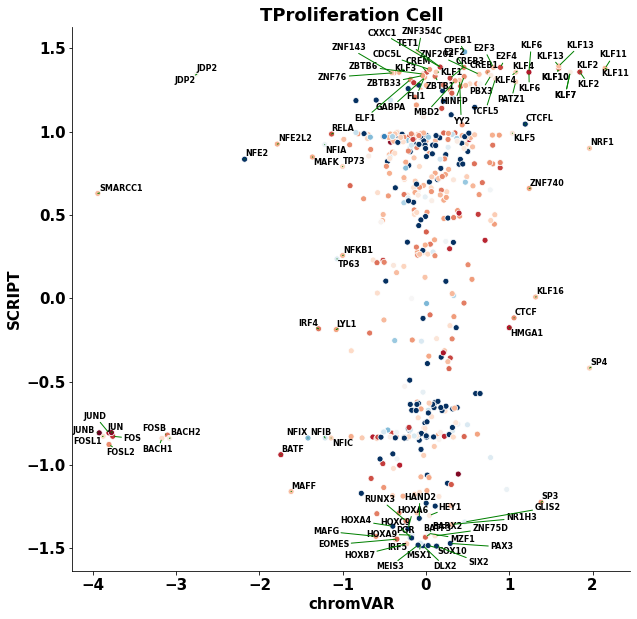

In [140]:
cell = 'TProliferation'
data = locals()[cell + "_table"]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data=data, x='chromVAR', y='SCRIPT', hue='expression', palette='RdBu_r', ax=ax, legend=False)
ax.set_title('%s Cell' % cell)
texts = []
for i in range(len(data.index)):
    if abs(data.iloc[i,1]) > 1:
        texts.append(plt.text(data.iloc[i,1], data.iloc[i,2], data.index[i], size=8))
    if abs(data.iloc[i,2]) > 1.3:
        texts.append(plt.text(data.iloc[i,1], data.iloc[i,2], data.index[i], size=8))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='green'))
fig.show()

### Recall ratio

In [581]:
with open('TF_names_v_1.01.txt', 'r') as file_handle:    
    TF_list = [i.rstrip('\n') for i in file_handle.readlines()]

In [582]:
tf_ovlp_factor = list(set(TF_list) & set(expression.index))

In [612]:
script_motif_table = pbmc_script_adata.uns['motif_z'].copy()

script_ChIP_table = pbmc_script_adata.uns['ChIP_z'].copy()

script_table = pbmc_script_adata.uns['integrated_z'].copy()
script_table.columns=[i[2:] for i in script_table.columns]
# script_table = script_table.drop(['CPEB1', 'ZNF354C'], axis=1)

In [613]:
ovlp_factor = set(expression.index) & set(script_table.columns) & set(chromVAR_table.columns) & set(script_ChIP_table.columns) & set(script_motif_table.columns)

In [635]:
ch_ovlp_factor = set(expression.index) & set(chromVAR_table.columns)
sc_ovlp_factor = set(expression.index) & set(script_table.columns)
sc_chip_ovlp_factor = set(expression.index) & set(script_ChIP_table.columns)
sc_motif_ovlp_factor = set(expression.index) & set(script_motif_table.columns)

In [618]:
ovlp_factor.__len__()

146

In [622]:
expression

,B,DC,Mono_Macro,NK,T,pDC
AL627309.1,0.000000,0.000000,0.006200,0.002261,0.002683,0.015167
AL627309.4,0.001129,0.000000,0.018307,0.000000,0.002285,0.000000
AL669831.5,0.049625,0.056969,0.044034,0.040008,0.031515,0.034907
FAM87B,0.002184,0.000000,0.004799,0.000000,0.000980,0.024295
LINC00115,0.022140,0.064846,0.054379,0.019165,0.013433,0.020559
...,...,...,...,...,...,...
AL592183.1,0.071615,0.059088,0.020158,0.036860,0.047631,0.024584
AC007325.4,0.002446,0.006406,0.004953,0.003019,0.007544,0.013072
AL354822.1,0.005864,0.005632,0.002107,0.004552,0.002702,0.011435
AC004556.1,0.061753,0.110774,0.034569,0.054417,0.060255,0.038406


In [627]:
chromVAR_table

,TFAP2B,TFAP2D,TFAP2C,TFAP2E,TFAP2A,ARID3A,ARID5B,ARID3B,ARID5A,ARID3C,...,PBX4,NKX62,HOXA4,CR8477943,RORB,SMAD5,SMAD9,SOX6,TBX18,TBX22
AAACAAGCACCACAAA,1.303155,-0.434590,-0.457119,0.965786,1.826718,0.222399,0.496754,-0.528345,-1.312826,-0.526592,...,0.842919,-0.305863,0.971412,0.427137,-1.044701,-0.917601,-0.342049,-0.336527,1.151196,1.151196
AAACAAGCAGCCAGTG,-0.976182,-1.168322,-0.749624,0.111072,-1.766978,1.799998,-0.155039,-0.134317,-0.192148,-1.253129,...,-0.720390,-0.669256,0.848806,1.072767,-1.286486,-0.828982,0.438613,-0.563324,-0.276718,-0.276718
AAACAAGCAGGACCTG,-0.306004,0.017620,-2.098204,-0.322960,0.011830,0.517261,1.146561,-0.352097,1.455611,1.236955,...,1.297821,0.715016,-0.548809,-1.734624,0.300097,0.831536,0.480913,0.069200,-0.268239,-0.268239
AAACAAGCATTGACTC,-1.007423,0.323479,-1.280677,-0.166447,0.446602,1.483417,-0.550072,1.051917,-0.922795,1.730456,...,0.060741,1.454022,1.212289,-1.754932,-0.939455,-0.047612,-0.010529,-0.102109,1.562885,1.562885
AAACAAGCATTGTTTG,-0.730665,-2.272845,-1.342869,0.210156,-0.269242,1.594789,2.052390,-0.832631,-0.345750,-0.674169,...,0.286168,-0.039768,-0.742604,1.295154,1.026998,-0.273359,-2.540347,-0.008690,0.580615,0.580615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCGAGGTGGCTA,-0.013423,-0.799812,0.496376,0.917468,0.017925,0.169166,-0.353570,0.610647,1.344225,-1.007314,...,0.536884,0.813049,1.305287,-0.697667,1.368993,-0.547129,-0.603766,0.577488,-1.279311,-1.279311
TTTGTGAGTACCTTGG,1.685638,0.145448,-0.257251,-0.655742,-0.480001,1.011504,2.912024,1.957431,1.021042,0.636026,...,1.403189,2.490445,1.535583,1.330865,2.118625,-0.473756,-0.481643,0.214739,2.689893,2.689893
TTTGTGAGTCATGAAG,0.623155,-0.161078,-0.115077,-1.991842,-2.108227,0.748301,-2.055235,2.969763,-0.743320,1.941854,...,-0.655526,0.041744,-0.956059,-0.746708,-0.027294,1.116511,-0.517152,1.549040,0.364667,0.364667
TTTGTGAGTGCAATAG,-1.938859,-0.064810,-1.381009,-1.163329,0.697171,1.176247,0.303462,-0.235745,0.805261,-1.139156,...,-0.156648,-0.144521,0.325093,0.590291,0.587448,1.176031,0.029297,0.091389,-1.017517,-1.017517


In [629]:
chromVAR_table.loc[cell_bc, ch_ovlp_factor]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['CTAACCTCATGTCATC', 'TAACAGGGTAGGAGGA', 'TCATGCATCCTTAGTG',\n       'TCTATTGCAGGCGAAA'],\n      dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [636]:
result = {}
for cell in expression.columns:
#     expression100 = set(expression.loc[ovlp_factor,cell].sort_values(ascending=False)[0:50].index)
    expression100 = set(expression[expression[cell]>np.median(expression[cell])].index)
    cell_bc = metadata[(metadata['assign.celltype'] == cell)].index
    chromvar_cell_bc = set(cell_bc) & set(chromVAR_table.index)
    chromvar100 = set(chromVAR_table.loc[chromvar_cell_bc, ch_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    script100 = set(script_table.loc[cell_bc, sc_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    script_motif_100 = set(script_motif_table.loc[cell_bc, sc_motif_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    script_chip_100 = set(script_ChIP_table.loc[cell_bc, sc_chip_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    c_tp = expression100.intersection(chromvar100).__len__()
    c_fn = (expression100 - chromvar100).__len__()
#     c_pre = c_tp/(c_tp+)
    c_recall = c_tp/100
    
    result[cell] = {'chromvar':expression100.intersection(chromvar100).__len__(),
                    'script_integrate':expression100.intersection(script100).__len__(),
                   'script_motif (not full)':expression100.intersection(script_motif_100).__len__(),
                   'script_ChIP':expression100.intersection(script_chip_100).__len__(),}
#                     'consistant':chromvar100.intersection(script100).__len__()}
result = pd.DataFrame(result)

data = (result/100).T.melt()

data['type'] = list(result.columns)*4

In [637]:
data

,variable,value,type
0,chromvar,0.68,B
1,chromvar,0.74,DC
2,chromvar,0.77,Mono_Macro
3,chromvar,0.62,NK
4,chromvar,0.61,T
5,chromvar,0.68,pDC
6,script_integrate,0.88,B
7,script_integrate,0.81,DC
8,script_integrate,0.71,Mono_Macro
9,script_integrate,0.75,NK


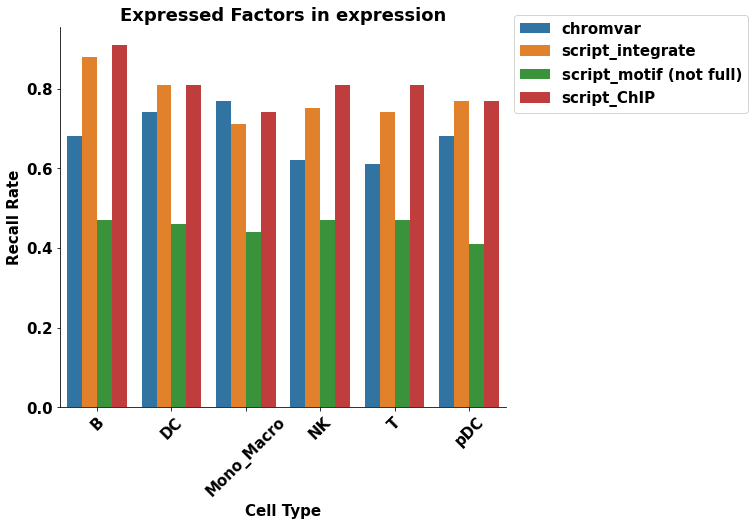

In [639]:
fig, ax = plt.subplots(figsize=(8,7))
sns.barplot(data=data, x="type", y="value", hue="variable")
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_xlabel('Cell Type')
ax.set_ylabel('Recall Rate')
ax.set_title('Expressed Factors in expression')
fig.show()

### NMI

In [29]:
# filter bad bed files
bed_peak_number = pd.read_csv('/mnt/Storage/home/dongxin/Projects/scATAC/human/peak_number.txt', sep=' ', header = None)

In [30]:
bad_factor = set([i.split('_')[1].split('.')[0] for i in bed_peak_number[bed_peak_number.iloc[:,1] < 3000][0]])

In [31]:
good_factor = set(script_table.columns) - bad_factor

In [ ]:
sns.distplot(chromVAR_table_file['TCF7'])

In [37]:
script_table = script_adata.uns['ChIP_z']
script_table = script_table.loc[:,good_factor].copy()
script_table = script_table.replace([np.inf, -np.inf], np.nan)
script_table = script_table.dropna(axis=1,how='any')
sudo_expression_SCRIPT = ad.AnnData(script_table)

In [ ]:
sns.displot(script_table['EOMES'])

In [38]:
script_table = script_table.replace([np.inf, -np.inf], np.nan)
script_table = script_table.dropna(axis=1,how='any')

In [35]:
script_table.columns = [i[2:] for i in script_table.columns]

In [ ]:
for i in script_table.index:
    print(i + '\t' + str(np.std(script_table.loc[i,])))

In [ ]:
script_table

In [69]:
sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack')
# sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=40, n_pcs=30)
sc.tl.umap(sudo_expression_SCRIPT)
sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.7)

sudo_expression_SCRIPT.obs['Cluster']=atac_adata.obs['seurat_clusters'][sudo_expression_SCRIPT.obs.index]
sudo_expression_SCRIPT.obs['Celltype']=atac_adata.obs['assign.celltype'][sudo_expression_SCRIPT.obs.index]
sudo_expression_SCRIPT.obs['Accurate Celltype']=atac_adata.obs['assign.accurate.celltype'][sudo_expression_SCRIPT.obs.index]

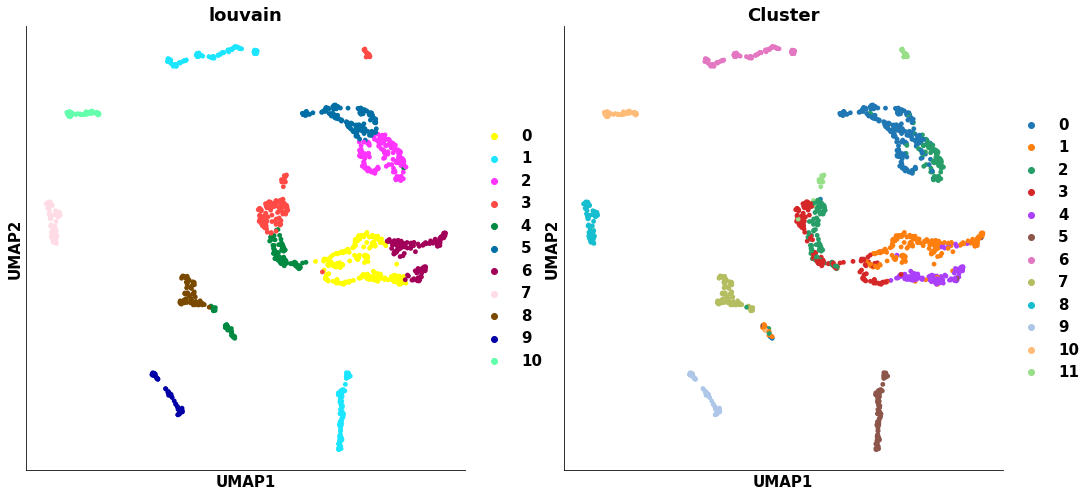

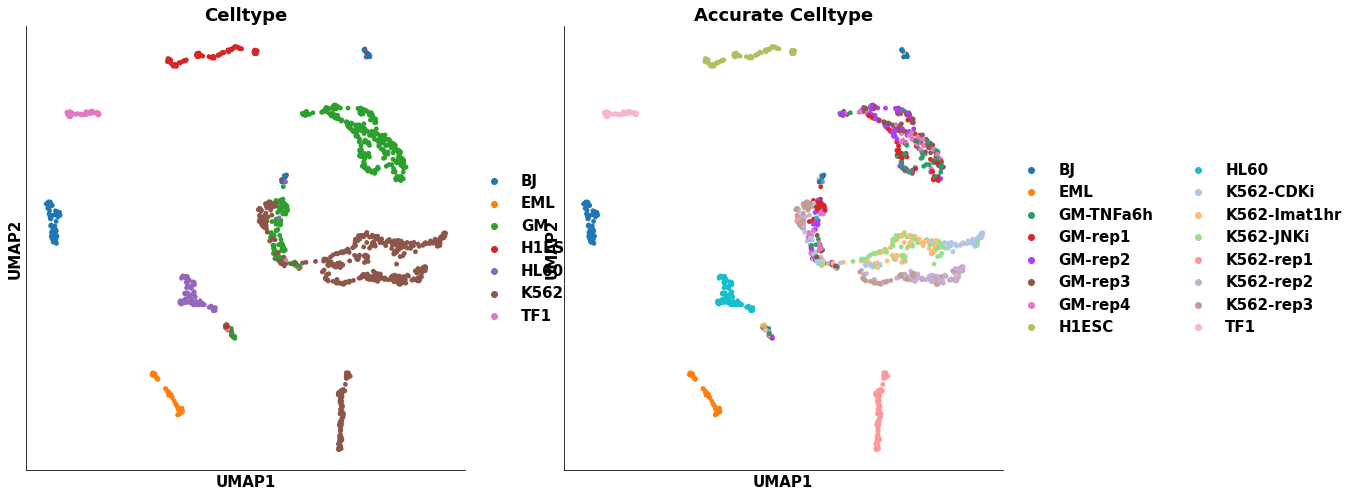

In [70]:
sc.pl.umap(sudo_expression_SCRIPT, color=['louvain', 'Cluster'])
sc.pl.umap(sudo_expression_SCRIPT, color=['Celltype', 'Accurate Celltype'])

In [44]:
sudo_expression_SCRIPT

AnnData object with n_obs × n_vars = 1296 × 519
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [154]:
chromVAR_table = pd.read_csv('example/10X_ATAC/chromVar_result_table.txt', sep='\t')
sudo_expression_chromVAR = ad.AnnData(chromVAR_table)

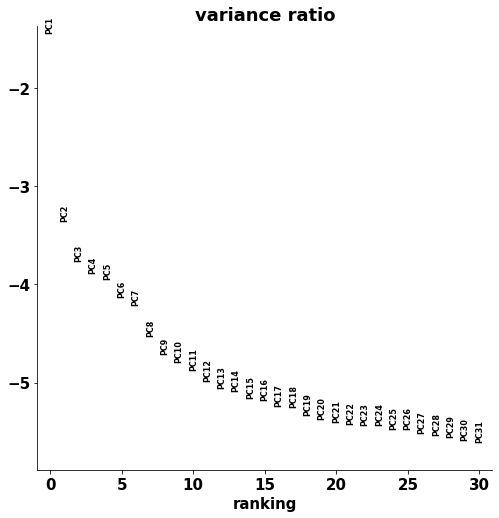

In [155]:
sc.tl.pca(sudo_expression_chromVAR, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_chromVAR, log=True)
sc.pp.neighbors(sudo_expression_chromVAR, n_neighbors=10, n_pcs=40)
sc.tl.umap(sudo_expression_chromVAR)
sc.tl.louvain(sudo_expression_chromVAR, resolution=0.6)

sudo_expression_chromVAR.obs['RNA_cluster']=pbmc_script_adata.obs['seurat_clusters'][sudo_expression_chromVAR.obs.index]
sudo_expression_chromVAR.obs['RNA_cell_type']=pbmc_script_adata.obs['assign.celltype'][sudo_expression_chromVAR.obs.index]

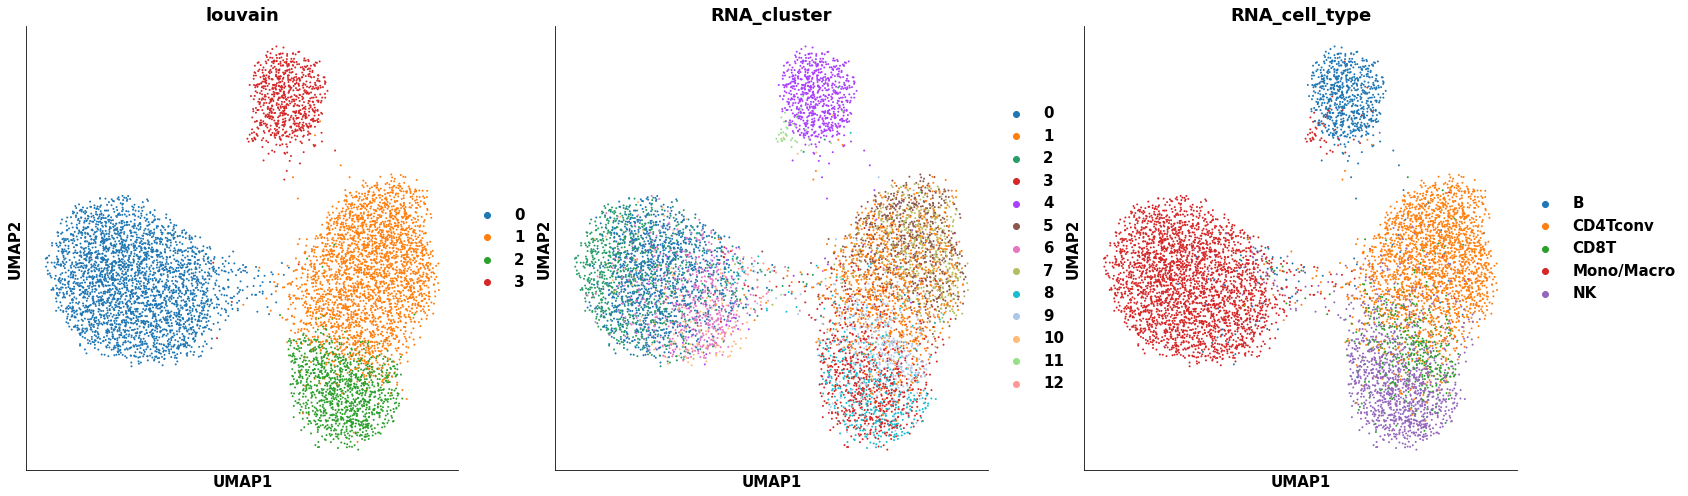

In [157]:
sc.pl.umap(sudo_expression_chromVAR, color=['louvain', 'RNA_cluster','RNA_cell_type'])

In [ ]:
sc.pl.umap(sudo_expression_SCRIPT, color='louvain')

In [ ]:
sc.pl.umap(sudo_expression_SCRIPT, color='TBX21')

In [10]:
chromVAR_table_file = pd.read_csv('example/10X_ATAC/chromVAR_z_table.txt', sep='\t')

In [11]:
chromVAR_table = chromVAR_table_file.replace([np.inf, -np.inf], np.nan)
chromVAR_table = chromVAR_table.dropna(axis=1,how='any')

In [12]:
sudo_expression_chromVAR = ad.AnnData(chromVAR_table)

In [445]:
sudo_expression_chromVAR

AnnData object with n_obs × n_vars = 37818 × 869

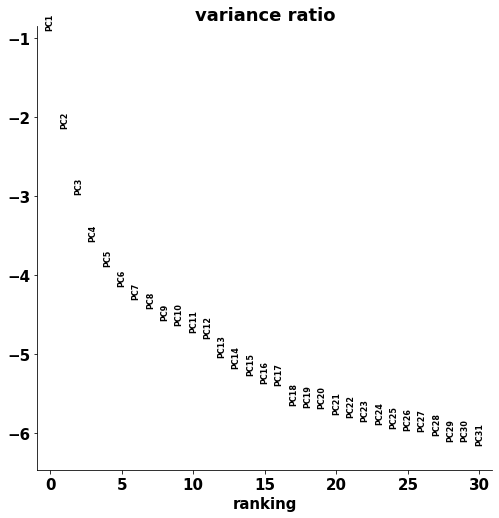

In [13]:
sc.tl.pca(sudo_expression_chromVAR, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_chromVAR, log=True)
sc.pp.neighbors(sudo_expression_chromVAR, n_neighbors=10, n_pcs=40)
sc.tl.umap(sudo_expression_chromVAR)

In [14]:
sc.tl.louvain(sudo_expression_chromVAR, resolution=0.8)

In [20]:
sudo_expression_chromVAR.obs['cell_type']=gold_cluster[sudo_expression_chromVAR.obs.index]

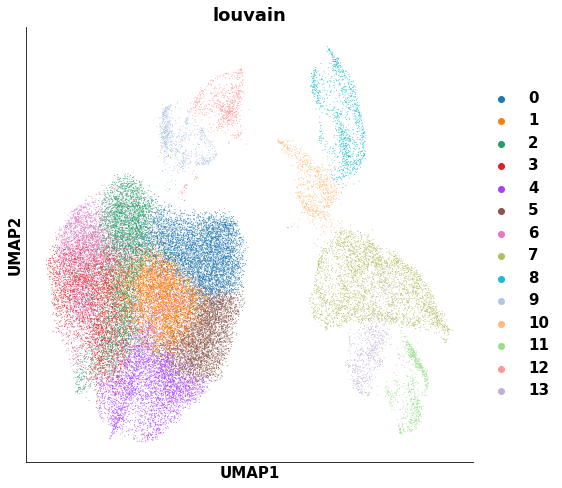

In [15]:
sc.pl.umap(sudo_expression_chromVAR, color='louvain')

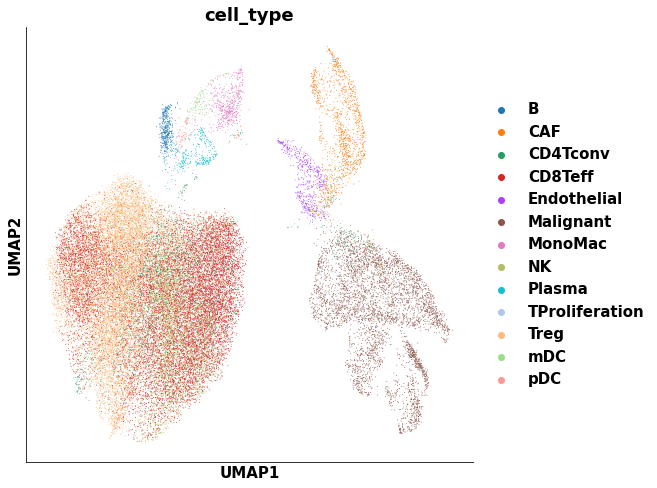

In [456]:
sc.pl.umap(sudo_expression_chromVAR, color='cell_type')

In [146]:
gold_cluster = metadata[metadata['tech']=='ATAC']['assign.ident']

In [23]:
real = gold_cluster[sudo_expression_chromVAR.obs.index]

In [45]:
script_nmi = sudo_expression_SCRIPT.obs['louvain'][sudo_expression_chromVAR.obs.index]
# chromvar_nmi = sudo_expression_chromVAR.obs['louvain'][sudo_expression_chromVAR.obs.index]

In [46]:
sklearn.metrics.normalized_mutual_info_score(real, script_nmi)

0.43982752132746

In [24]:
sklearn.metrics.normalized_mutual_info_score(real, chromvar_nmi)

0.4307002815428866

In [81]:
seurat_adata.obs['assign.celltype']=="B"

AAACGAAAGACACGGT    False
AAACGAAAGAGGTGGG    False
AAACGAAAGCACGTAG    False
AAACGAAAGCGCCTAC    False
AAACGAAAGCTTTCCC    False
                    ...  
TTTGTGTGTCCTATTT    False
TTTGTGTGTGCGTTTA    False
TTTGTGTGTGGCGCTT    False
TTTGTGTTCCGTTTCG    False
TTTGTGTTCGCGCTGA    False
Name: assign.celltype, Length: 7573, dtype: bool

In [86]:
inputmat

,chr10_100009409_100010370,chr10_100020344_100020844,chr10_100045992_100046450,chr10_10004_10426,chr10_100148689_100148853,chr10_100167512_100167918,chr10_100183568_100183733,chr10_100185426_100186618,chr10_100192474_100192634,chr10_100228843_100229860,...,chrY_7658983_7659334,chrY_7667828_7668166,chrY_7714481_7714782,chrY_7722639_7722800,chrY_7724052_7724763,chrY_7730142_7730519,chrY_7810584_7810819,chrY_7814235_7814827,chrY_8535794_8536106,chrY_9516722_9516902
AAACGAAAGACACGGT,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGAGGTGGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGCACGTAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGCGCCTAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGCTTTCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTGTCCTATTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGTGTGCGTTTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGTGTGGCGCTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGTTCCGTTTCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
inputmat = pbmc_10X_inputMat.to_df()

In [89]:
B_cluster = inputmat.loc[seurat_adata.obs[seurat_adata.obs['assign.celltype']=="B"].index,:]

In [95]:
B_cluster

,chr10_100009409_100010370,chr10_100020344_100020844,chr10_100045992_100046450,chr10_10004_10426,chr10_100148689_100148853,chr10_100167512_100167918,chr10_100183568_100183733,chr10_100185426_100186618,chr10_100192474_100192634,chr10_100228843_100229860,...,chrY_7658983_7659334,chrY_7667828_7668166,chrY_7714481_7714782,chrY_7722639_7722800,chrY_7724052_7724763,chrY_7730142_7730519,chrY_7810584_7810819,chrY_7814235_7814827,chrY_8535794_8536106,chrY_9516722_9516902
AAACTCGAGCGAATAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
AAACTCGAGTCTTAGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGGGCTCCATGTTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGGGCTCTTGCGCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAATGCCAGCGTTGCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACGTTCCAGCACG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGAGGAGAGCTACG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGAGGGTCATAAGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGGCCCATTATGGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
peak = B_cluster.columns[B_cluster.sum(0)>10]

In [110]:
B_peak = [i.split('_') for i in peak]

In [111]:
B_peak.__len__()

32534

In [10]:
ref_gene = pd.read_csv('/mnt/Storage2/home/dongxin/Files/ref_files/hg38/hg38_refGene.bed', sep='\t')

In [33]:
ref_gene.drop_duplicates(['symbol'], 'first', True)

In [115]:
ref_gene['B_count']=count

In [116]:
ref_gene['B_count'].value_counts()

0    12580
1    12025
2      386
3        6
Name: B_count, dtype: int64

In [35]:
peak = [i.split('_') for i in pbmc_10X_inputMat.var['gene_ids']]

In [113]:
peak_dict = {}
for i in B_peak:
    center = int((int(i[1]) + int(i[2]))/2)
    if i[0] not in peak_dict.keys():
        peak_dict[i[0]] = [center]
    else:
        peak_dict[i[0]].append(center)

In [102]:
B_peak

[['chr10', '100009409', '100010370'],
 ['chr10', '100020344', '100020844'],
 ['chr10', '100045992', '100046450'],
 ['chr10', '100148689', '100148853'],
 ['chr10', '100167512', '100167918'],
 ['chr10', '100185426', '100186618'],
 ['chr10', '100228843', '100229860'],
 ['chr10', '100256880', '100257468'],
 ['chr10', '100266976', '100268067'],
 ['chr10', '100286009', '100287020'],
 ['chr10', '100297938', '100298245'],
 ['chr10', '100303820', '100303976'],
 ['chr10', '100326811', '100327446'],
 ['chr10', '100338413', '100338900'],
 ['chr10', '100339296', '100339659'],
 ['chr10', '100346458', '100347612'],
 ['chr10', '100370700', '100371560'],
 ['chr10', '100373123', '100374149'],
 ['chr10', '100420044', '100420310'],
 ['chr10', '100433674', '100434215'],
 ['chr10', '100481431', '100482900'],
 ['chr10', '100508664', '100509436'],
 ['chr10', '100510796', '100511418'],
 ['chr10', '100518716', '100519399'],
 ['chr10', '100529108', '100530205'],
 ['chr10', '100535541', '100536241'],
 ['chr10', '

In [46]:
ref_gene.index.__len__()

24997

In [114]:
count = [0] * ref_gene.index.__len__()
for i in ref_gene.index:
    print(i,end='\r')
    chro = ref_gene.loc[i,'chromosome']
    for pc in peak_dict[chro]:
        if ref_gene.loc[i,'TSS'] - 1000 < pc < ref_gene.loc[i,'TSS'] + 1000:
            count[i] += 1
        else:
            continue

<AxesSubplot:>

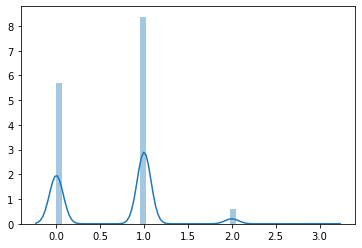

In [71]:
sns.distplot(count,norm_hist=False)

In [16]:
bg_table = read_giggle_result_batch('example/10X_ATAC/SCRIPT_result_20210111/bg_chip_result/')

INFO 2021-01-13 18:39:02 Reading searching results, using 8 cores...


In [23]:
print_full(bg_table.apply(np.std, axis=1))

id
1006_EOMES                              5.96
1007_EP300                             13.37
1010_FOXH1                              7.29
1011_FOXH1                             10.25
1012_FOXP1                             16.93
1013_FOXP1                             16.37
1080_SMAD2or3                           7.52
1082_SMAD2or3                          15.34
1084_SMAD3                              5.58
1085_SMAD3                             16.51
1086_SMAD4                             25.53
1087_SMAD4                             16.31
1168_POLR3G                           105.10
1173_ELK4                              40.62
1175_TRIM28                            11.21
1194_TRIM28                            13.20
1197_BRF1                             120.07
11_TCF4                                12.55
1208_DDX5                              19.22
1212_E2F1                              23.25
1213_ELK1                              20.15
1214_ELK4                              18.21
1218_GA

In [25]:
print_full(bg_table.apply(np.std, axis=1) * bg_table.apply(np.mean, axis=1))

id
1006_EOMES                            118.49
1007_EP300                         12,432.53
1010_FOXH1                            248.25
1011_FOXH1                          7,526.77
1012_FOXP1                         24,262.19
1013_FOXP1                         22,768.36
1080_SMAD2or3                         283.36
1082_SMAD2or3                      18,807.34
1084_SMAD3                            116.48
1085_SMAD3                         21,085.64
1086_SMAD4                          6,014.36
1087_SMAD4                         21,592.70
1168_POLR3G                        89,514.82
1173_ELK4                          73,405.66
1175_TRIM28                        10,825.73
1194_TRIM28                        12,163.78
1197_BRF1                         111,019.07
11_TCF4                             9,743.06
1208_DDX5                          29,789.04
1212_E2F1                          39,022.60
1213_ELK1                          32,355.39
1214_ELK4                          28,615.67
1218_GA

In [24]:
print_full(bg_table.apply(np.mean, axis=1))

id
1006_EOMES                             19.87
1007_EP300                            929.87
1010_FOXH1                             34.07
1011_FOXH1                            734.44
1012_FOXP1                          1,433.21
1013_FOXP1                          1,390.83
1080_SMAD2or3                          37.68
1082_SMAD2or3                       1,225.94
1084_SMAD3                             20.88
1085_SMAD3                          1,277.41
1086_SMAD4                            235.61
1087_SMAD4                          1,323.52
1168_POLR3G                           851.72
1173_ELK4                           1,807.01
1175_TRIM28                           965.34
1194_TRIM28                           921.23
1197_BRF1                             924.60
11_TCF4                               776.46
1208_DDX5                           1,549.87
1212_E2F1                           1,678.46
1213_ELK1                           1,605.68
1214_ELK4                           1,571.20
1218_GA

## chip impute

In [15]:
def get_motif_pattern_from_minimal(motif_file):
    with open(motif_file,'r') as handle:
        motif_record = motifs.parse(handle,'minimal')
    IUPAC_dict = {'R':'[AG]', 'Y':'[CT]', 'W':'[AT]', 'S':'[CG]', 'M':'[AC]', 'K':'[GT]', 'H':'[ACT]', 'B':'[CGT]', 'V':'[ACG]', 'D':'[AGT]', 'N':'[ACGT]'}
    motif_pattern = []
    for motif in motif_record:
        motif_seq = str(motif.degenerate_consensus)
        for k in IUPAC_dict.keys():
            motif_seq = motif_seq.replace(k, IUPAC_dict[k])
        motif_pattern.append(re.compile(motif_seq))
    return motif_pattern        

In [159]:
ref_fa = pysam.FastaFile("/mnt/Storage/home/dongxin/Files/FASTA_REFERENCE/hg38.fa")

In [16]:
def filter_motif_peaks(peak, motif_pattern):
    motif_peak_dict = {}
    cnt = 0
    for interval in peak.df.T.to_dict().values():
        interval_seq = str(ref_fa.fetch(reference=interval['Chromosome'],
                                        start=interval['Start'], end=interval['End']).upper())
        interval_seq = interval_seq[int(interval_seq.__len__()/2)-250 : int(interval_seq.__len__()/2+250)]
        for p in motif_pattern:
            if p.findall(interval_seq) != []:
    #             print(p.findall(interval_seq))
                motif_peak_dict[cnt] = interval
                break
        cnt += 1
    motif_peak = pd.DataFrame(motif_peak_dict).T
    return motif_peak


In [ ]:
def RP_AddExonRemovePromoter(peaks_info, genes_info_full, genes_info_tss, decay):
    """Multiple processing function to calculate regulation potential."""

    Sg = lambda x: 2**(-x)
    checkInclude = lambda x, y: all([x>=y[0], x<=y[1]])
    gene_distance = 15 * decay
    genes_peaks_score_array = sp_sparse.dok_matrix((len(genes_info_full), len(peaks_info)), dtype=np.float64)
    peaks_info_inbody = []
    peaks_info_outbody = []
    
    w = genes_info_full + peaks_info
    A = {}

    w.sort()
#     print(w[:100])
    for elem in w:
        if elem[-3] == 1:
            A[elem[-1]] = elem
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                ### NOTE: main change here
                ### if peak center in the gene area
                if all([g[0]==elem[0], elem[1]>=g[1], elem[1]<=g[2]]):
                    ### if peak center in the exons
                    if any(list(map(checkInclude, [elem[1]]*len(g[5]), list(g[5])))):
                        genes_peaks_score_array[gene_name, elem[-1]] = 1.0 / g[-4]
                        peaks_info_inbody.append(elem)
                    ### if peak cencer in the promoter
                    elif checkInclude(elem[1], g[4]):
                        tmp_distance = abs(elem[1]-g[3])
                        genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
                        peaks_info_inbody.append(elem)
                    ### intron regions
                    else:
                        continue
                else:
                    dlist.append(gene_name)
            for gene_name in dlist:
                del A[gene_name]
    
    ### remove genes in promoters and exons
    peaks_info_set = [tuple(i) for i in peaks_info]
    peaks_info_inbody_set = [tuple(i) for i in peaks_info_inbody]
    peaks_info_outbody_set = list(set(peaks_info_set)-set(peaks_info_inbody_set))
    peaks_info_outbody = [list(i) for i in peaks_info_outbody_set]
    
    print("peaks number: ", len(peaks_info_set))
    print("peaks number in gene promoters and exons: ", len(set(peaks_info_inbody_set)))
    print("peaks number out gene promoters and exons:", len(peaks_info_outbody_set))
    
    w = genes_info_tss + peaks_info_outbody
    A = {}
    
    w.sort()
    for elem in w:
        if elem[-3] == 1:
            A[elem[-1]] = elem
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = elem[1] - g[1]
                if all([g[0]==elem[0], tmp_distance <= gene_distance]):
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
                else:
                    dlist.append(gene_name)
            for gene_name in dlist:
                del A[gene_name]

    w.reverse()
    for elem in w:
        if elem[-3] == 1:
            A[elem[-1]] = elem
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = g[1] - elem[1]
                if all([g[0]==elem[0], tmp_distance <= gene_distance]):
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
                else:
                    dlist.append(gene_name)
            for gene_name in dlist:
                del A[gene_name]
    
    return(genes_peaks_score_array)

In [49]:
peaks_list

[b'chr10_100009409_100010370',
 b'chr10_100020344_100020844',
 b'chr10_100045992_100046450',
 b'chr10_10004_10426',
 b'chr10_100148689_100148853',
 b'chr10_100167512_100167918',
 b'chr10_100183568_100183733',
 b'chr10_100185426_100186618',
 b'chr10_100192474_100192634',
 b'chr10_100228843_100229860',
 b'chr10_100240861_100241083',
 b'chr10_100254185_100254476',
 b'chr10_100256880_100257468',
 b'chr10_100266976_100268067',
 b'chr10_100277711_100278027',
 b'chr10_100286009_100287020',
 b'chr10_100291405_100291878',
 b'chr10_100292352_100292544',
 b'chr10_100297938_100298245',
 b'chr10_100303820_100303976',
 b'chr10_100326811_100327446',
 b'chr10_100338413_100338900',
 b'chr10_100339296_100339659',
 b'chr10_100346458_100347612',
 b'chr10_100364781_100365131',
 b'chr10_100370700_100371560',
 b'chr10_100373123_100374149',
 b'chr10_100420044_100420310',
 b'chr10_100433674_100434215',
 b'chr10_100481431_100482900',
 b'chr10_100508664_100509436',
 b'chr10_100510796_100511418',
 b'chr10_1005187

In [28]:
gene_bed = '/mnt/Storage2/home/dongxin/Projects/scATAC/MAESTRO/MAESTRO/annotations/GRCh38_refgenes.txt'
genes_info, genes_list = geneInfoSimple(gene_bed)

In [29]:
peaks_list = input_mat.columns
peaks_list = [p.encode() for p in peaks_list]
peaks_info= []
for ipeak, peak in enumerate(peaks_list):
    peaks_tmp = peak.decode().rsplit("_",maxsplit=2)
    peaks_info.append([peaks_tmp[0][3:], (int(peaks_tmp[1]) + int(peaks_tmp[2])) / 2.0, 0, ipeak])

In [50]:
genes_peaks_score_dok = RP_Simple(peaks_info, genes_info, 10000)

In [14]:
with open('example/10X_ATAC/RP_impute/peak_RP.pk', 'wb+') as f:
    pickle.dump(genes_peaks_score_dok, f)

In [ ]:
input_mat

In [117]:
# cluster rp
cell_type = set(seurat_adata.obs['assign.celltype'])
celltype_peak_mat = pd.DataFrame(np.zeros([cell_type.__len__(), input_mat.columns.__len__()]), index=cell_type, columns = input_mat.columns)
for ct in cell_type:
    ct_bc = seurat_adata.obs.index[seurat_adata.obs['assign.celltype'] == ct].to_list()
    celltype_peak_mat.loc[ct,:] = [1 if i else 0 for i in input_mat.loc[ct_bc,:].sum() >= 1]

In [133]:
with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_ct_peak.pk' , 'wb+') as f:
    pickle.dump(sp.sparse.csr_matrix(celltype_peak_mat), f)

In [ ]:
# chip_cell_peak = pd.DataFrame(np.zeros(ret_cell_peak_10_dense.shape), index = ret_cell_peak_10_dense.index, columns = ret_cell_peak_10_dense.columns)
# chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/82369_BCL11A.bed.gz')
# for cell_bc in ret_cell_peak_10_dense.index:
#     print(1)
#     pl = ret_cell_peak_10_dense.columns[ret_cell_peak_10_dense.loc[cell_bc,:] == 1]
#     tmp_bed = pybedtools.BedTool('\n'.join([p[::-1].replace('_','\t',2)[::-1] for p in pl]), from_string=True)
#     print(2)
#     chip_peak = str(tmp_bed.intersect(chip_bed, u=True)).replace('\t','_').split('\n')
#     print(3)
#     print(chip_peak.__len__())
#     for c in chip_peak:
#         chip_cell_peak.at[cell_bc,c] = 1

## dict of RNA ATAC

In [18]:
coor_table = pd.DataFrame(seurat_adata.obsm['X_umap'], index = seurat_adata.obs.index, columns=["X","Y"])

In [21]:
i = 50

ret_cell_peak = cal_neighbor_cell_peak_mat_batch(input_mat, coor_table, i, 8)

with open('example/PBMC/neighbor_impute/ret_cell_peak_signal_%s.pk' % str(i),'wb+') as f:
    pickle.dump(ret_cell_peak, f)

INFO 2021-03-25 19:20:49 Calculating enrichment, divide into 8 chunks...
0
1
2
3
4
5
6
7
INFO 2021-03-25 21:25:46 finished!


In [ ]:
i = 50
with open('example/PBMC/neighbor_impute/ret_cell_peak_signal_%s.pk' % str(i),'rb+') as f:
    ret_cell_peak = pickle.load(f)

In [23]:
np.sqrt(ret_cell_peak)

,chr10_100009284_100010367,chr10_100020473_100021014,chr10_100045988_100046455,chr10_10004_10427,chr10_100167498_100168427,chr10_100168868_100169192,chr10_100183499_100183734,chr10_100185396_100186614,chr10_100192314_100192840,chr10_100228797_100230018,...,chrY_56836532_56836952,chrY_56838854_56839093,chrY_56839328_56839739,chrY_56842236_56842543,chrY_56843024_56843878,chrY_56845075_56845389,chrY_56846947_56847228,chrY_56847794_56848071,chrY_56848693_56849075,chrY_56850217_56851134
AAACAAGCACCACAAA,2.828427,0.0,0.0,0.0,0.000000,0.0,0.000000,3.000000,0.00000,2.236068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGCAGCCAGTG,1.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,1.000000,0.00000,1.414214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGCAGGACCTG,2.449490,0.0,1.0,0.0,0.000000,0.0,0.000000,4.123106,0.00000,3.741657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGCATTGACTC,4.472136,0.0,1.0,0.0,1.000000,0.0,1.000000,3.605551,0.00000,4.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGCATTGTTTG,3.162278,0.0,0.0,0.0,1.414214,0.0,0.000000,4.795832,0.00000,3.605551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCGAGGTGGCTA,3.000000,0.0,1.0,0.0,0.000000,0.0,2.645751,3.000000,2.44949,4.123106,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGAGTACCTTGG,4.358899,0.0,0.0,0.0,0.000000,0.0,1.414214,4.358899,0.00000,4.472136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGAGTCATGAAG,2.645751,1.0,1.0,0.0,1.000000,0.0,1.000000,4.690416,0.00000,3.872983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGAGTGCAATAG,2.828427,0.0,0.0,0.0,1.414214,1.0,0.000000,4.123106,0.00000,4.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
find_nearest_cells('AAACGAAAGACACGGT', coor_table, n_neighbor=50, step=None)

## here

In [122]:
input_mat = pbmc_10X_inputMat.to_df()
input_mat = input_mat.loc[atac_adata.obs.index,:].copy()

In [123]:
gene_bed = '/mnt/Storage2/home/dongxin/Projects/scATAC/MAESTRO/MAESTRO/annotations/GRCh38_refgenes.txt'
genes_info, genes_list = geneInfoSimple(gene_bed)

In [124]:
with open('example/PBMC/neighbor_impute/ret_cell_peak_signal_50.pk' , 'rb+') as f:
    ret_cell_peak = pickle.load(f)

In [ ]:
ret_cell_peak

In [ ]:
# ret_cell_peak = pd.DataFrame(ret_cell_peak.todense(), index=input_mat.index, columns=input_mat.columns)

### config rp TF

In [863]:
factor='BCL11A'
cells_intrest=['B', 'Mono_Macro']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/82369_BCL11A.bed.gz')

In [880]:
factor='BCL11B'
cells_intrest=['NK', 'T']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/73986_BCL11B.bed.gz')

In [895]:
factor='EBF1'
cells_intrest=['B', 'Mono_Macro', 'T']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/46129_EBF1.bed.gz')

In [903]:
factor='CEBPA'
cells_intrest=['B', 'T', 'Mono_Macro']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/48277_CEBPA.bed.gz')

In [910]:
factor='TBX21'
cells_intrest=['B', 'NK', 'T']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/33678_TBX21.bed.gz')

In [919]:
factor='FOXO1'
cells_intrest=['B', 'NK', 'T', 'Mono_Macro']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/58300_FOXO1.bed.gz')


In [920]:
# chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Files/cistrome/human/human_factor/46129_sort_peaks.narrowPeak.bed')
tmp_bed = pybedtools.BedTool('\n'.join(['\t'.join(p.rsplit('_', maxsplit=2)) for p in ret_cell_peak.columns]), from_string=True) # p[::-1].replace('_','\t',2)[::-1]
chip_peak = str(tmp_bed.intersect(chip_bed, u=True)).replace('\t','_').split('\n')[0:-1]

chip_peak.__len__()

# chip_cell_peak = np.sqrt(chip_cell_peak)

chip_cell_peak = ret_cell_peak[chip_peak].copy()

cells_list = chip_cell_peak.index

peaks_list = chip_cell_peak.columns.tolist()
# peaks_list = [p.encode() for p in peaks_list]
peaks_info= []
for ipeak, peak in enumerate(peaks_list):
    peaks_tmp = peak.rsplit("_", maxsplit=2)
    peaks_info.append([peaks_tmp[0][3:], (int(peaks_tmp[1]) + int(peaks_tmp[2])) / 2.0, 0, ipeak])

genes_peaks_score_dok = RP_Simple(peaks_info, genes_info, 10000)

genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
genes_cells_score_csr = genes_peaks_score_csr.dot(sp.sparse.csr_matrix(chip_cell_peak).T)

score_cells_dict = {}
score_cells_sum_dict = {}

for igene, gene in enumerate(genes_list):
    score_cells_dict[gene] = igene
    score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

score_cells_dict_dedup = {}
score_cells_dict_max = {}
genes = list(set([i.split("@")[0] for i in genes_list]))
for gene in genes:
    score_cells_dict_max[gene] = float("-inf")

for gene in genes_list:
    symbol = gene.split("@")[0]
    if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
        score_cells_dict_dedup[symbol] = score_cells_dict[gene]
        score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
gene_symbol = sorted(score_cells_dict_dedup.keys())
matrix_row = []
for gene in gene_symbol:
    matrix_row.append(score_cells_dict_dedup[gene])

score_cells_matrix = genes_cells_score_csr[matrix_row, :]

RP_table = pd.DataFrame(score_cells_matrix.todense(), index=gene_symbol, columns=cells_list)


/mnt/Storage/home/dongxin/Applications/miniconda3/envs/test/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [921]:
sub_RP_table = RP_table[RP_table.sum(axis=1) != 0]# .loc[:,cell_type_bc]

In [922]:
with open('example/PBMC/RP_result/50_fraction_%s_RP_table.pk' % factor,'wb+') as file:
    pickle.dump(sub_RP_table, file)


In [911]:
with open('example/PBMC/RP_result/50_fraction_%s_RP_table.pk' % factor,'rb') as file:
    sub_RP_table = pickle.load(file)

In [923]:
sub_RP_table_z = sub_RP_table.apply(sp.stats.zscore, axis='index')

In [ ]:
# genes_peaks_dense = pd.DataFrame(genes_peaks_score_dok.todense(),index = genes_list, columns = peaks_list)
# genes_peaks_dense[[i.startswith('SPRY3') for i in genes_peaks_dense.index]].max().sort_values()
# cell_type_bc = atac_seurat_adata.obs[seurat_adata.obs['assign.ident'] == 'B'].index.tolist()

In [849]:
plot_adata = atac_adata.copy()
plot_adata.obs = pd.concat([atac_adata.obs, sub_RP_table_z.T.reindex(index=atac_adata.obs.index)], axis=1)
plot_adata.var.index = ['R_' + i for i in plot_adata.var.index]

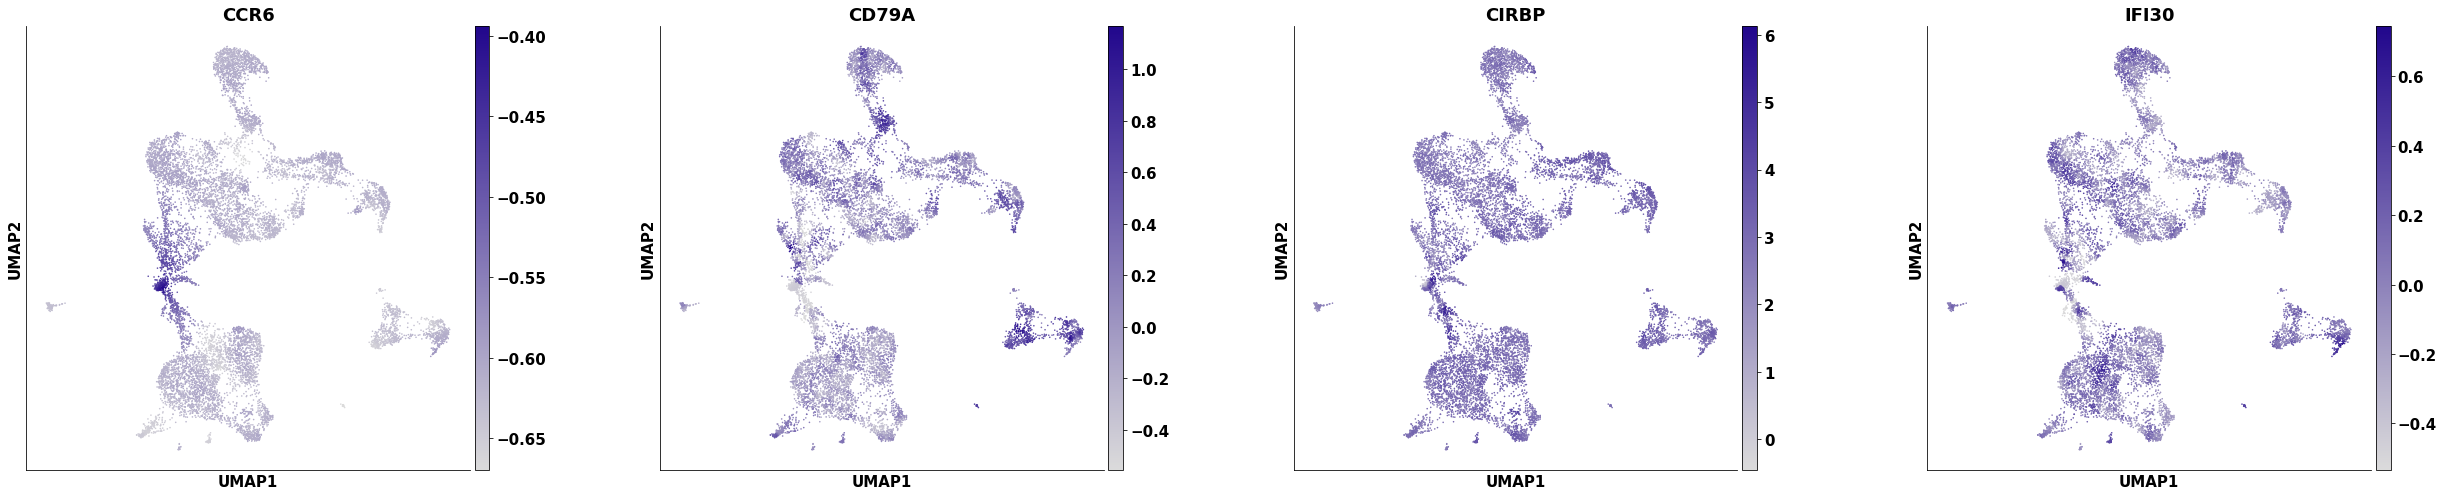

In [707]:
# for i in ['STAT1','CD86','IRF5','NOTCH1','CCDC107','IRF9']:
# for i in ['IRF9']:
# sc.pl.umap(plot_adata, color= ['SLAMF7','CD86','IRF5','NOTCH1','MS4A1','CD19','CD79A', 'IGKC'], wspace=0.3, color_map=regulation_cmp)
sc.pl.umap(plot_adata, color= ['CCR6','CD79A','CIRBP','IFI30'], wspace=0.3, color_map=regulation_cmp)

In [924]:
target_gene_list = []
target_gene_list += sub_RP_table_z.max(1).sort_values(ascending=False)[0:300].index.tolist()
target_gene_list += sub_RP_table_z.std(1).sort_values(ascending=False)[0:300].index.tolist()
target_gene_list = set(target_gene_list)
tg_list = [g for g in target_gene_list if g in rna_expr.columns] 

In [925]:
cell_barcode_rna = []
for cell in cells_intrest:
    cell_barcode_rna += rna_adata.obs[(rna_adata.obs['assign.ident']==cell)].index.tolist()


keys.index = keys['RNA']
cell_barcode_atac = keys.loc[cell_barcode_rna]['ATAC'].values

cell_barcode_atac = [i for i in cell_barcode_atac if i in pbmc_script_adata.obs.index]

keys.index = keys['ATAC']
cell_barcode_rna = keys.loc[cell_barcode_atac]['RNA'].values

In [926]:
tar_expr = rna_expr.loc[cell_barcode_rna,tg_list + [factor]].copy()

tf_RP = sub_RP_table_z.loc[tg_list,cell_barcode_atac].T

coor = []
pvalue = []
# rp_corr = []
for i in tf_RP.columns:
    tmp = sp.stats.spearmanr(tar_expr[factor], tar_expr[i])
    if not np.isnan(tmp.correlation):
        coor.append(tmp.correlation)
        pvalue.append(tmp.pvalue)
    else:
        coor.append(0)
        pvalue.append(1)
#     tmp1 = sp.stats.spearmanr(tf_RP[i], tar_expr[i])
#     rp_corr.append(tmp1.correlation)

tf_RP = sub_RP_table_z.loc[tg_list,cell_barcode_atac].T.median()

data = pd.DataFrame(np.array([coor,tf_RP, -np.log(pvalue)]).T, columns = ['corr', 'RP', '-log.p'], index = tg_list)

In [916]:
# tf_regu = pbmc_script_adata.obs['I_'+factor].loc[cell_barcode_atac,]

55


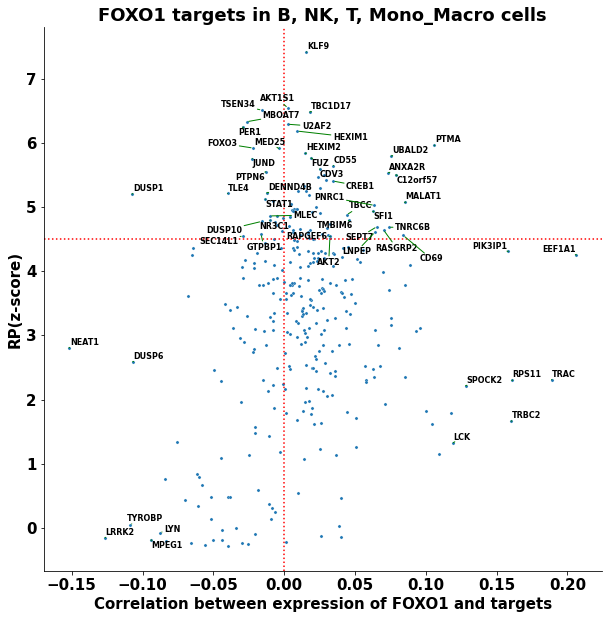

In [927]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data=data, x = 'corr', y = 'RP', s=10)

x_q02 = data.iloc[:,0].quantile(0.98)
x_q25 = data.iloc[:,0].quantile(0.75)
x_q75 = data.iloc[:,0].quantile(0.25)
x_q98 = data.iloc[:,0].quantile(0.02)
y_q25 = data.iloc[:,1].quantile(0.75)
y_q05 = data.iloc[:,1].quantile(0.95)

texts = []
for i in range(len(data.index)):
    if data.iloc[i,0] > x_q02:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,0] < x_q98:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,1] > y_q05:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,1] > y_q25 and data.iloc[i,0] > x_q25:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,1] > y_q25 and data.iloc[i,0] < x_q75:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
print(texts.__len__())
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='green'))

for hl in [y_q25]:
    ax.axhline(hl, linestyle=':', color='red')
for vl in [0]:
    ax.axvline(vl, linestyle=':', color='red')
    
ax.set_xlabel('Correlation between expression of %s and targets' % factor)
ax.set_ylabel('RP(z-score)')
ax.set_title('%s targets in %s cells' % (factor, ', '.join(cells_intrest)))
fig.show()

In [426]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(sub_RP_table)

In [ ]:
# sns.heatmap(sub_RP_table.iloc[0:100,:], xticklabels=False, yticklabels=False, cmap='RdBu_r')

RP11-134P9.3     42.470775
PSME2            41.784596
RNF31            41.532952
RP11-398A8.3     41.301670
GNAI2            39.421524
                   ...    
PRRT2            31.717071
RP11-440L14.1    31.664623
AC009133.23      31.606836
EIF4ENIF1        31.601642
RHOG             31.593741
Length: 100, dtype: float64

In [131]:
a = sub_RP_table.sum(axis=1).sort_values(ascending=False)

In [129]:
sub_RP_table

,AAACTCGAGCGAATAT,AAACTCGAGTCTTAGC,AAAGGGCTCCATGTTT,AAAGGGCTCTTGCGCT,AAATGCCAGCGTTGCC,AACAAAGGTAATGCAA,AACAGTCCAGGCTACC,AACAGTCTCTCTTAAC,AACCAACTCTGACTTT,AACCGATGTACGGATG,...,TTGCTTATCTTCTTCC,TTGGTCCTCGAGGTAG,TTGTTCAAGGCCAGTA,TTGTTGTCATCGACGC,TTGTTGTCATTGAACC,TTTACGTTCCAGCACG,TTTGAGGAGAGCTACG,TTTGAGGGTCATAAGA,TTTGGCCCATTATGGC,TTTGGTTCACAAGGGT
A1BG,0.281810,0.242142,0.369600,0.177019,0.280370,0.203914,0.215248,0.220914,0.143738,0.143738,...,0.094176,0.061615,0.225861,0.276143,0.177739,0.310144,0.099843,0.164966,0.099843,0.253476
A1BG-AS1,0.266700,0.222594,0.345656,0.168841,0.255772,0.189417,0.202018,0.208319,0.136500,0.136500,...,0.090721,0.063845,0.209156,0.260399,0.174305,0.298204,0.097022,0.150775,0.097022,0.235196
A2ML1,0.007843,0.004991,0.009269,0.003565,0.004991,0.004278,0.000713,0.003565,0.004278,0.004278,...,0.007130,0.003565,0.006417,0.004991,0.002852,0.013547,0.004278,0.003565,0.005704,0.006417
A3GALT2,0.000840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000840,0.000000,0.000000,0.000840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A4GALT,1.401102,0.972065,0.751330,1.483036,1.192243,1.038830,0.833014,1.490917,1.684511,1.684511,...,2.489696,1.577759,0.481178,1.484263,0.754147,1.747224,2.458621,1.314864,1.744892,0.481869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM4,0.565665,0.213596,0.702233,0.520143,0.120645,0.148340,0.324375,0.575532,0.148340,0.148340,...,0.296680,0.176035,0.176035,0.462848,0.213596,0.549743,0.176035,0.306547,0.168074,0.203729
ZSWIM8,0.048418,0.048418,0.110660,0.036314,0.060523,0.060523,0.048802,0.060523,0.036314,0.036314,...,0.096837,0.036314,0.012105,0.085495,0.084732,0.158123,0.048418,0.012868,0.121238,0.024209
ZSWIM8-AS1,0.144136,0.144136,0.329420,0.108102,0.180170,0.180170,0.145279,0.180170,0.108102,0.108102,...,0.288271,0.108102,0.036034,0.254509,0.252238,0.470713,0.144136,0.038305,0.360911,0.072068
ZYG11B,0.020776,0.012466,0.029087,0.027009,0.014543,0.012466,0.016621,0.027009,0.010388,0.010388,...,0.008310,0.010388,0.016621,0.029087,0.018699,0.033242,0.010388,0.012466,0.010388,0.016621


In [ ]:
a[0:50]

In [ ]:
for i in [5, 10, 20, 50, 75, 100]:
    print(i)
    locals()['ret_cell_peak_%s' % str(i)] = cal_neighbor_cell_peak_mat_batch(input_mat, coor_table, i, 8)
    with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_cell_peak_%s.pk' % str(i),'wb+') as f:
        pickle.dump(locals()['ret_cell_peak_%s' % str(i)], f)
    print_log('Finish saving.')

In [15]:
cells_list = input_mat.index.to_list()

# for i in [50, 75, 100]:
#     print(i)
#     with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_cell_peak_%i.pk' % i,'rb+') as f:
#         ret_cell_peak = pickle.load(f)

#     cell_peaks_csr = sp.sparse.csr_matrix(ret_cell_peak)

    genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
    genes_cells_score_csr = genes_peaks_score_csr.dot(ret_cell_peak.T)

    score_cells_dict = {}
    score_cells_sum_dict = {}

    for igene, gene in enumerate(genes_list):
        score_cells_dict[gene] = igene
        score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

    score_cells_dict_dedup = {}
    score_cells_dict_max = {}
    genes = list(set([i.split("@")[0] for i in genes_list]))
    for gene in genes:
        score_cells_dict_max[gene] = float("-inf")

    for gene in genes_list:
        symbol = gene.split("@")[0]
        if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
            score_cells_dict_dedup[symbol] = score_cells_dict[gene]
            score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
    gene_symbol = sorted(score_cells_dict_dedup.keys())
    matrix_row = []
    for gene in gene_symbol:
        matrix_row.append(score_cells_dict_dedup[gene])

    score_cells_matrix = genes_cells_score_csr[matrix_row, :]

    RP_table = pd.DataFrame(score_cells_matrix.todense(), index=gene_symbol, columns=cells_list)

    with open('example/10X_ATAC/RP_impute/RP_%s_cell.pk' %i, 'wb+') as f:
        pickle.dump(RP_table, f)

50
75
100


In [94]:
# write_10X_h5('example/10X_ATAC/RP_impute/RP_5_cell.h5', score_cells_matrix, gene_symbol, cells_list, genome=gene_bed.split("/")[-1].split("_")[0], datatype="Gene")

In [137]:
cell_peaks_csr = sp.sparse.csr_matrix(celltype_peak_mat)

genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
genes_cells_score_csr = genes_peaks_score_csr.dot(cell_peaks_csr.T)

score_cells_dict = {}
score_cells_sum_dict = {}

for igene, gene in enumerate(genes_list):
    score_cells_dict[gene] = igene
    score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

score_cells_dict_dedup = {}
score_cells_dict_max = {}
genes = list(set([i.split("@")[0] for i in genes_list]))
for gene in genes:
    score_cells_dict_max[gene] = float("-inf")

for gene in genes_list:
    symbol = gene.split("@")[0]
    if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
        score_cells_dict_dedup[symbol] = score_cells_dict[gene]
        score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
gene_symbol = sorted(score_cells_dict_dedup.keys())
matrix_row = []
for gene in gene_symbol:
    matrix_row.append(score_cells_dict_dedup[gene])

score_cells_matrix = genes_cells_score_csr[matrix_row, :]

RP_table = pd.DataFrame(score_cells_matrix.todense(), index=gene_symbol, columns=cell_type)

with open('example/10X_ATAC/RP_impute/cluster_rp.pk' , 'wb+') as f:
    pickle.dump(RP_table, f)

In [ ]:
RP_table

In [24]:
# plot
# load dataset
with open('example/10X_ATAC/RP_impute/cluster_rp.pk' , 'rb+') as f:
    cluster_rp = pickle.load(f)
for i in [5,10,20,50,75,100]:
    with open('example/10X_ATAC/RP_impute/RP_%s_cell.pk' %i, 'rb+') as f:
        locals()['RP_%s_cell' %i] = pickle.load(f)

In [45]:
result_dict = {}
result_dict['cell_type']=[]
result_dict['impute_number']=[]
result_dict['difference_sum']=[]
result_dict['std.']=[]
for ct in cluster_rp.columns:
    ct_bc = seurat_adata.obs.index[seurat_adata.obs['assign.celltype'] == ct].to_list()
    tmp_cluster_mat = pd.DataFrame(np.zeros([cluster_rp.index.__len__(), ct_bc.__len__()]), index=cluster_rp.index, columns = ct_bc)
    for i in tmp_cluster_mat.columns:
        tmp_cluster_mat[i] = cluster_rp[ct]
    for impu in [5,10,20,50,75,100]:
        diff = abs(locals()['RP_%s_cell' % impu].loc[:,ct_bc] - tmp_cluster_mat).sum().mean()
        std = locals()['RP_%s_cell' % impu].loc[:,ct_bc].std(1)
        std = std[std!=0].mean()
        result_dict['cell_type'].append(ct)
        result_dict['impute_number'].append(impu)
        result_dict['difference_sum'].append(diff)
        result_dict['std.'].append(std)

In [51]:
result_frame = pd.DataFrame.from_dict(result_dict)
with open('example/10X_ATAC/RP_impute/result.pk', 'wb+') as f:
    pickle.dump(result_frame, f)

In [59]:
result_frame[result_frame['cell_type']=='Mono/Macro']

,cell_type,impute_number,difference_sum,std.
0,Mono/Macro,5,75143.564980,0.351939
1,Mono/Macro,10,65312.304338,0.367111
2,Mono/Macro,20,54337.776462,0.362915
3,Mono/Macro,50,39596.649533,0.346345
4,Mono/Macro,75,33217.711931,0.332186
5,Mono/Macro,100,28861.766474,0.318797


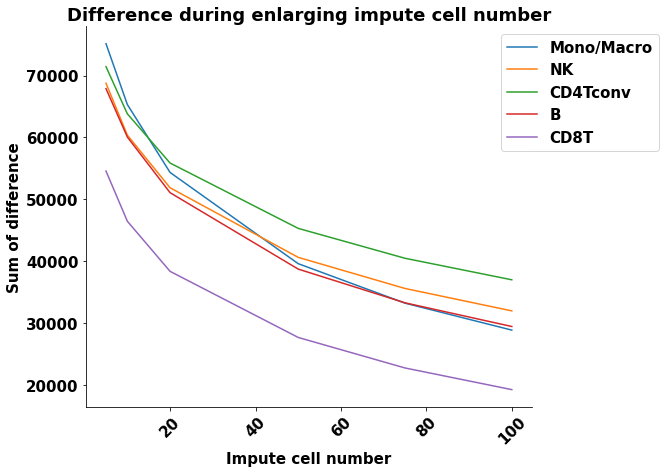

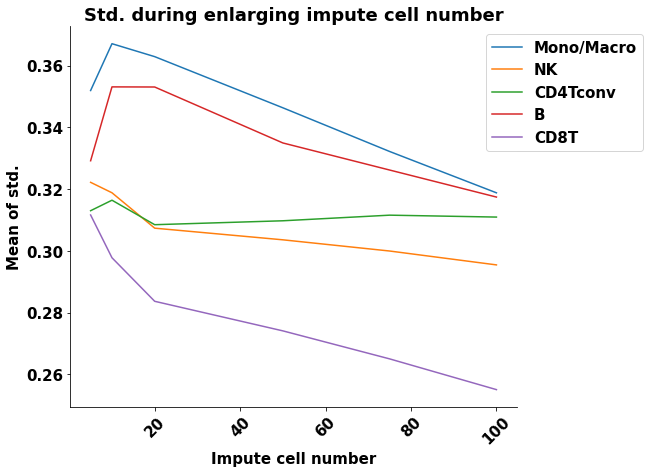

In [90]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="difference_sum", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.3, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Sum of difference')
ax.set_title('Difference during enlarging impute cell number')
fig.show()
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="std.", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.3, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Mean of std.')
ax.set_title('Std. during enlarging impute cell number')
fig.show()

In [73]:
for i in [5,10,20,50,75,100]:
    with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_cell_peak_%s.pk' % str(i),'rb+') as f:
        locals()['ret_cell_peak_%s' % str(i)] = pickle.load(f)

In [86]:
peak_number = []
for i in [5,10,20,50,75,100]:
    peak_number.append(locals()['ret_cell_peak_%s' % str(i)].sum(1).mean())


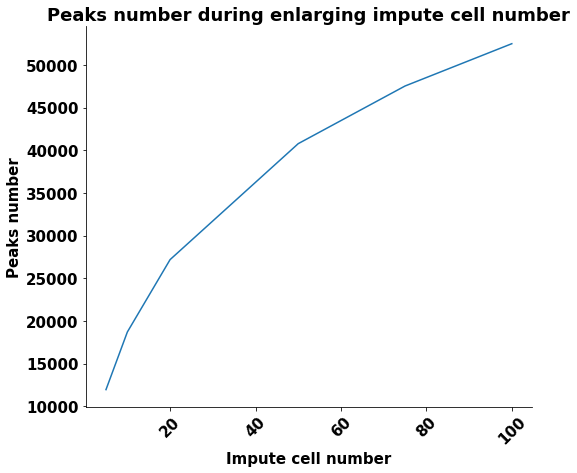

In [89]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(x=[5,10,20,50,75,100], y=peak_number)
plt.xticks(rotation=45)
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Peaks number')
ax.set_title('Peaks number during enlarging impute cell number')
fig.show()

In [ ]:
# plot peak

In [12]:
item = {}
for i in seurat_adata.obs['assign.ident'].unique():
    item[i]=(seurat_adata.obs[seurat_adata.obs['assign.ident'] == i].__len__())

In [41]:
seurat_adata.obs[seurat_adata.obs['assign.ident'] == i].index

427

In [40]:
item

{'CD4Tconv': 2201, 'Mono/Macro': 2920, 'NK': 1240, 'B': 785, 'CD8T': 427}

In [42]:
for k in item.keys():
    generate_beds('example/10X_ATAC/activate_impute/result/foreground/'+k.replace('/','_')+'.bed', seurat_adata.obs[seurat_adata.obs['assign.ident'] == k].index.tolist(), pbmc_10X_inputMat, 5)

In [44]:
for k in item.keys():
    search_giggle('example/10X_ATAC/activate_impute/result/foreground/'+k.replace('/','_')+'.bed.gz', 'example/10X_ATAC/activate_impute/result/foreground/txt/chip/'+k.replace('/','_')+'.txt', human_chip_index)
    search_giggle('example/10X_ATAC/activate_impute/result/foreground/'+k.replace('/','_')+'.bed.gz', 'example/10X_ATAC/activate_impute/result/foreground/txt/motif/'+k.replace('/','_')+'.txt', human_motif_index)

In [16]:
for k in item.keys():
    generate_background_bed(pbmc_10X_inputMat, 'example/10X_ATAC/activate_impute/'+k.replace('/','_'), 'example/10X_ATAC/activate_impute/'+k.replace('/','_')+'.pk', step=item[k], iteration=1000, peak_confidence=5, n_cores=8)

INFO 2021-02-27 20:13:59 Start generating background beds ...
INFO 2021-02-27 20:46:27 Finished generating background beds!
INFO 2021-02-27 20:46:27 Start generating background beds ...
INFO 2021-02-27 21:23:20 Finished generating background beds!
INFO 2021-02-27 21:23:20 Start generating background beds ...
INFO 2021-02-27 21:45:27 Finished generating background beds!
INFO 2021-02-27 21:45:27 Start generating background beds ...
INFO 2021-02-27 22:02:05 Finished generating background beds!
INFO 2021-02-27 22:02:05 Start generating background beds ...
INFO 2021-02-27 22:15:03 Finished generating background beds!


In [17]:
for k in item.keys():
    search_giggle_batch('example/10X_ATAC/activate_impute/'+k.replace('/','_'), 'example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip', human_chip_index, n_cores=8)
    search_giggle_batch('example/10X_ATAC/activate_impute/'+k.replace('/','_'), 'example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_motif', human_motif_index, n_cores=8) 

In [21]:
for k in item.keys():
    result_chip = read_giggle_result_batch('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip', n_cores=8)
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip.pk','wb') as result_file:
        pickle.dump(result_chip, result_file)
    result_motif = read_giggle_result_batch('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_motif', n_cores=8)
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_motif.pk','wb') as result_file:
        pickle.dump(result_motif, result_file)

INFO 2021-03-01 09:52:39 Reading searching results, using 8 cores...
INFO 2021-03-01 09:52:48 Reading searching results, using 8 cores...
INFO 2021-03-01 09:52:52 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:04 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:09 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:14 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:20 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:28 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:31 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:41 Reading searching results, using 8 cores...


In [25]:
for k in item.keys():
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip.pk','rb') as result_file:
        result_chip = pickle.load(result_file)
    factor_result_chip = map_factor_on_ChIP(result_chip)
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip_factor.pk','wb') as result_file:
        pickle.dump(factor_result_chip, result_file)        

INFO 2021-03-01 11:20:25 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:26 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:28 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:30 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:34 Summary result from dataset level to factor level.


In [45]:
cell_type_table = read_giggle_result_batch('example/10X_ATAC/activate_impute/result/foreground/txt/chip', n_cores=1)

INFO 2021-03-01 14:01:45 Reading searching results, using 1 cores...


In [48]:
with open('example/10X_ATAC/activate_impute/result/CD4Tconv_chip.pk','rb') as result_file:
    bg_table = pickle.load(result_file)
cal_rank(cell_type_table['CD4Tconv'][0], bg_table.loc[0,:])

INFO 2021-03-01 14:25:28 chunk 1 calculating ...


IndexingError: Too many indexers

In [61]:
mat = []
for i,k in enumerate(item.keys()):
    n = k.replace('/','_')

    l = []
    with open('example/10X_ATAC/activate_impute/result/%s_chip.pk' % n,'rb') as result_file:
        bg_table = pickle.load(result_file)
    for i in range(cell_type_table[n].__len__()):
        l.append(cal_rank(cell_type_table[n][i], bg_table.iloc[i,:]))
    mat.append(l)

In [ ]:
cell_type_table

In [78]:
with open('example/10X_ATAC/activate_impute/result/chip_dataset_celltype_table.pk','wb') as file:
    pickle.dump(cell_type_table, file)

In [73]:
df = pd.DataFrame(mat).T

In [79]:
with open('example/10X_ATAC/activate_impute/result/chip_dataset_celltype_rank_table.pk','wb') as file:
    pickle.dump(df, file)

In [88]:
for i in [5,10,20,50,75,100]:
    tmp = sc.read_h5ad('example/10X_ATAC/SCRIPT_result_20210125_%s/10X_ATAC_script_computed_20210111.h5ad' %i)
    locals()['enrich_%s_table' %i ] = tmp.uns['ChIP_p'].T

In [89]:
enrich_5_table

,AACCTTTCATGGTTTG,AAACTGCGTTTGGATC,AACAGTCAGGTTAACA,AATACGCCAAGTGGCA,AAACTGCAGTTATGAG,AGCCGCAGTTGGGAAC,ATAGTCGTCAGGTCTA,AGTGCGCTCCGGGCAT,AGCGTATCATCCCAAA,ACAAACCCATCAGAAA,...,TTGGTCCTCGACTCGG,TTTACGTTCGTAGCGC,TTACTTGTCCTGTAGA,TTATGTCTCGTTGTAG,TTCGGTCGTTGGGAAC,TTGCGAAAGTCAGGAC,TTGGTCCTCCGAGAGA,TTTGAGGCAGCCACGT,TTAGCGAAGTCACACT,TTCGGTCGTTATGCAC
AATF,0.972,0.063,0.501,0.934,0.268,0.948,0.917,0.650,0.954,0.022,...,0.466,0.168,0.289,0.294,0.363,0.368,0.384,0.791,0.591,0.745
ADNP,0.468,0.087,0.580,0.194,0.001,0.598,0.900,0.506,0.734,0.023,...,0.542,0.005,0.548,0.216,0.022,0.231,0.177,0.593,0.001,0.906
AEBP2,0.862,0.673,0.437,0.786,0.002,0.942,0.898,0.588,0.707,0.022,...,0.152,0.003,0.945,0.870,0.037,0.827,0.027,0.979,0.004,0.743
AFF1,0.889,0.289,0.281,0.322,0.001,0.987,0.760,0.481,0.128,0.017,...,0.027,0.001,0.053,0.405,0.065,0.748,0.041,0.529,0.009,0.641
AFF4,0.955,0.480,0.557,0.965,0.001,0.931,0.851,0.544,0.874,0.028,...,0.231,0.001,0.973,0.275,0.061,0.809,0.066,0.969,0.005,0.724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN5B,0.857,0.698,0.559,0.717,0.206,0.965,0.862,0.738,0.960,0.001,...,0.638,0.022,0.741,0.435,0.123,0.790,0.091,0.956,0.839,0.668
ZTA,0.657,0.362,0.496,0.045,0.778,0.420,0.635,0.318,0.936,0.140,...,0.560,0.537,0.066,0.229,0.930,0.577,0.081,0.406,0.866,0.565
ZXDB,0.993,0.723,0.529,0.990,0.001,0.990,0.945,0.785,0.709,0.094,...,0.243,0.004,0.998,0.868,0.096,0.973,0.085,0.999,0.002,0.911
ZXDC,0.530,0.575,0.484,0.956,0.001,0.888,0.940,0.461,0.647,0.190,...,0.061,0.002,0.976,0.913,0.094,0.996,0.313,0.992,0.010,0.940


In [90]:
cluster_enrich = map_factor_on_ChIP(df)

INFO 2021-03-01 16:45:24 Summary result from dataset level to factor level.


In [95]:
cluster_enrich.columns = ['CD4Tconv','Mono/Macro','NK','B','CD8T']

In [96]:
result_dict = {}
result_dict['cell_type']=[]
result_dict['impute_number']=[]
result_dict['difference_sum']=[]
result_dict['std.']=[]
for ct in cluster_enrich.columns:
#     ct = ct.replace('_','/')
    ct_bc = seurat_adata.obs.index[seurat_adata.obs['assign.celltype'] == ct].to_list()
    tmp_cluster_mat = pd.DataFrame(np.zeros([cluster_enrich.index.__len__(), ct_bc.__len__()]), index=cluster_enrich.index, columns = ct_bc)
    for i in tmp_cluster_mat.columns:
        tmp_cluster_mat[i] = cluster_enrich[ct]
    for impu in [5,10,20,50,75,100]:
        diff = abs(locals()['enrich_%s_table' % impu].loc[:,ct_bc] - tmp_cluster_mat).sum().mean()
        std = locals()['enrich_%s_table' % impu].loc[:,ct_bc].std(1)
        std = std[std!=0].mean()
        result_dict['cell_type'].append(ct)
        result_dict['impute_number'].append(impu)
        result_dict['difference_sum'].append(diff)
        result_dict['std.'].append(std)

In [99]:
result_frame = pd.DataFrame.from_dict(result_dict)
with open('example/10X_ATAC/activate_impute/chip_final_result.pk', 'wb+') as f:
    pickle.dump(result_frame, f)

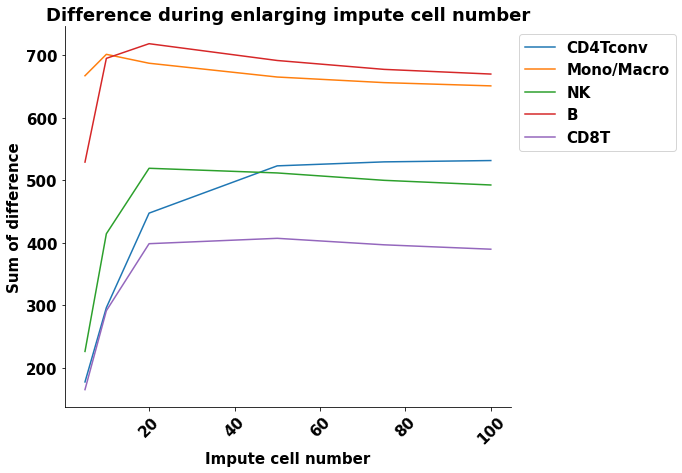

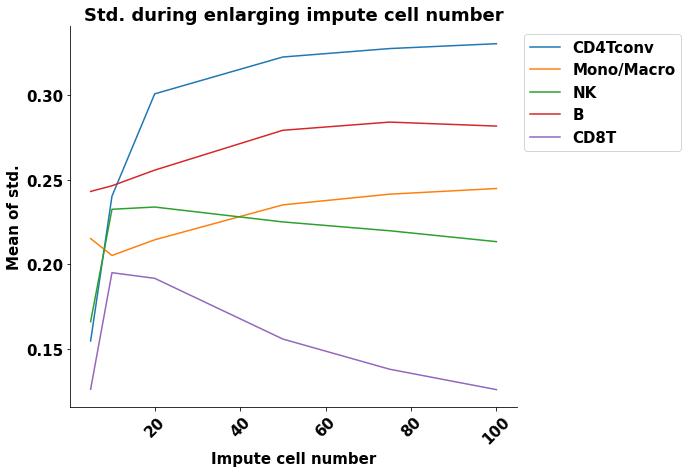

In [103]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="difference_sum", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Sum of difference')
ax.set_title('Difference during enlarging impute cell number')
fig.show()
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="std.", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Mean of std.')
ax.set_title('Std. during enlarging impute cell number')
fig.show()

----------
previous code

In [ ]:
CD4T_cluster = input_mat.loc[seurat_adata.obs[seurat_adata.obs['assign.celltype']=="CD4Tconv"].index,:]

In [194]:
CD4T_cluster.index

Index(['AAACGAAAGACACGGT', 'AAACGAAAGCTTTCCC', 'AAACGAAAGGCGTCCT',
       'AAACGAAAGTTTGGAA', 'AAACGAACAAACGACG', 'AAACGAATCCAACGCG',
       'AAACGAATCCATCTAT', 'AAACGAATCGGGACAA', 'AAACGAATCTGAACGT',
       'AAACTCGAGAAAGCAG',
       ...
       'TTTGGCCGTGACCAGA', 'TTTGGCCTCGCTCTAC', 'TTTGGTTAGTAATCAG',
       'TTTGGTTGTCAACAGG', 'TTTGGTTGTCGAGGAT', 'TTTGGTTGTCTGCGCA',
       'TTTGGTTGTTCTGAAC', 'TTTGGTTTCAGGCGCT', 'TTTGTGTGTGGCGCTT',
       'TTTGTGTTCGCGCTGA'],
      dtype='object', length=2201)

In [185]:
factor = 'STAT4'

In [195]:
cell_ch = pbmc_script_adata.uns['integrated_z'].loc[CD4T_cluster.index,:].sort_values(by='I_' + factor, ascending=False)['I_' + factor].index.to_list()[0]

In [196]:
cell_ch

'CCTGGGACAACCTCCT'

In [206]:
motif_pattern = get_motif_pattern_from_minimal('/mnt/Storage2/home/dongxin/Projects/motif/human_cisBP/meme/%s.meme' % factor)
result = pd.read_csv('example/10X_ATAC/temp/test/fg_chip_result/%s.txt' % cell_ch, sep='\t', index_col = False).sort_values('combo_score', ascending=False)
bulk_bed = result[[factor in i for i in result['#file']]]['#file'].to_list()[0]
# CGGACCATCCACACCT = pyranges.read_bed('10X_ATAC/temp/test/fg_bed/CGGACCATCCACACCT.bed.gz')
bulk_peak = pyranges.read_bed('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/' + bulk_bed)
cell_peak = pyranges.from_dict(pd.DataFrame([i.split('_') for i in input_mat.index[input_mat.loc[:,cell_ch] >= 1]]).rename(columns={0:'Chromosome', 1:'Start', 2:'End'}))
cell_peak_ovlp_with_bluk = cell_peak.overlap(bulk_peak)

cell_peak_unique = cell_peak.overlap(bulk_peak, invert=True)
cell_peak_unique_motif = filter_motif_peaks(cell_peak_unique,motif_pattern)
tmp = pyranges.from_dict(pd.concat([cell_peak_unique_motif, cell_peak_ovlp_with_bluk.df]))

In [208]:
tmp.to_bed('example/10X_ATAC/temp/%s_%s.bed' % (factor, cell_ch))

In [210]:
os.system('python ~/Projects/cidc_chips/modules/scripts/targets_RegPotential_Version2.py -p example/10X_ATAC/temp/%s_%s.bed -a /mnt/Storage/home/dongxin/Storage2/Files/ref_files/hg38/hg38_refGene.bed -n example/10X_ATAC/temp/%s_%s_gene_score.txt' % (factor, cell_ch,factor, cell_ch))

0

In [153]:
peak = pd.concat([cell_peak_unique_motif, cell_peak_ovlp_with_bluk.df])

,Chromosome,Start,End
1,chr1,103525148,103526464
2,chr1,107940936,107941713
3,chr1,108041499,108042115
5,chr1,108561836,108562005
7,chr1,109041377,109042498
...,...,...,...
1003,chrX,47144364,47145706
1004,chrX,49155865,49156655
1005,chrX,54639307,54640093
1006,chrX,72572385,72573360


In [445]:
# result = read_SingleCellExperiment_rds('example/small_HSC/HSC_single_cell_experiment.rds')
result.write_h5ad('example/small_HSC/HSC_single_cell_experiment.h5ad')

In [451]:
result.obs

,orig.ident,nCount_ATAC,nFeature_ATAC,ATAC_snn_res.0.6,seurat_clusters,ident
singles-BM0828-CMP-frozen-1511,example/small_HSC/ATAC,1805.0,1805,0,0,0
BM1077-CMP-Frozen-160106-3,example/small_HSC/ATAC,3671.0,3671,0,0,0
singles-20160617-scATAC-BM1077,example/small_HSC/ATAC,8163.0,8163,1,1,1
singles-160818-BM1137-pDC-LS-7,example/small_HSC/ATAC,14085.0,14085,6,6,6
singles-20160617-scATAC-BM1077.1,example/small_HSC/ATAC,5320.0,5320,1,1,1
...,...,...,...,...,...,...
singles-BM1214-MCP-frozen-1601.95,example/small_HSC/ATAC,2393.0,2393,6,6,6
singles-20160726-scATAC-BM1214.89,example/small_HSC/ATAC,3425.0,3425,0,0,0
singles-20160726-scATAC-BM1214.90,example/small_HSC/ATAC,3184.0,3184,7,7,7
BM1077-GMP-Frozen-160107-61,example/small_HSC/ATAC,3402.0,3402,5,5,5


In [477]:
data = sc.read_10x_h5('example/small_HSC/GSE96772_HSC_merged_count.h5', gex_only=False )
data.obs_names_make_unique(join='.')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [478]:
data.write_h5ad('example/small_HSC/GSE96772_HSC_merged_count.h5')

""
singles-BM0828-CMP-frozen-1511
BM1077-CMP-Frozen-160106-3
singles-20160617-scATAC-BM1077
singles-160818-BM1137-pDC-LS-7
singles-20160617-scATAC-BM1077.1
...
singles-BM1214-MCP-frozen-1601.95
singles-20160726-scATAC-BM1214.89
singles-20160726-scATAC-BM1214.90
BM1077-GMP-Frozen-160107-61
